In [1]:
#tools
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from pandas import DataFrame
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from acfunctions import *
import eleanor
from IPython.display import Image
import lightkurve as lk
from starspot import sigma_clipping
import starspot as ss
from lightkurve import search_targetpixelfile
from IPython.display import display, HTML
import starspot.rotation_tools as rt
from scipy import interpolate
import exoplanet
import eleanor
from bokeh.models import ColumnDataSource, LabelSet, Whisker
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df

import warnings
warnings.filterwarnings("ignore")

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
def find_m_b(x,y,err): #analytical approach to finding line of best fit 
    #C     
    errorsq = np.square(err)
    C = np.diag(errorsq)

    #A 
    xb = ([1] * len(x))
    mata = []
    for z, txt in enumerate(x):
        mata.append(x[z])
        mata.append(xb[z])
    A= np.matrix(mata).reshape((len(x), 2))

    #plugging in 
    At = np.transpose(A)
    invC = np.linalg.inv(C)
    pt1 = np.dot(At, np.dot(invC,A))
    invpt1= np.linalg.inv(pt1)
    pt2 = np.dot(At, np.dot(invC, y)).T
    cov = np.dot(invpt1, pt2)

    m = float(cov[0])
    b = float(cov[1])
    return m ,b 

def residuals(x, y, error): #residual abundance function
    mborig = find_m_b(x, y, error)
    m = mborig[0]
    b = mborig[1]

    predicted_values = [] #y values from slope
    pv = 0
    for u in x:
        pv = (m*u) + b
        predicted_values.append(pv)
        pv = 0

    prev = np.array(predicted_values)
    abu = np.array(y)
    diff = abu - prev #difference between slope and measured values  
    return diff

In [5]:
#dataset with tess vs kepler IDs
tess_kep = pd.read_csv('data_summary.csv')
tess_short = tess_kep[tess_kep.tess_ffi == True]
cat = pd.read_csv('tics_kics_mcq_rot.txt', names=['tic_id', 'kic_id', 'prot'], delim_whitespace=True)

In [6]:
#importing McQ periods
headers = 'TIC ID', 'KIC ID', 'McQ Periods';  

with open("tics_kics_mcq_rot.txt") as file:
    rot_table = [line.split() for line in file.read().splitlines()]

widths = [max(len(value) for value in col)
for col in zip(*(rot_table + [headers]))]

formatting = '{:{widths[0]}}  {:{widths[1]}}  {:{widths[2]}}'
formatting.format(*headers, widths=widths)
for tics_kics_mcq in rot_table:
    formatting.format(*tics_kics_mcq, widths=widths)

In [7]:
# converting txt file data to arrays
tic_ids = []
mcq_periods = []

for index, row in enumerate(rot_table):
    tic_ids.append(int(rot_table[index][0]))
    mcq_periods.append(float(rot_table[index][2]))

In [8]:
# selecting shortest periods only (<13 days, half a tess cycle)
short_periods = []
tics_short_periods = []

for index, period in enumerate(mcq_periods):
    if period < 13: 
        short_periods.append(period)
        tics_short_periods.append(tic_ids[index])

In [9]:
tic_super_short = []
for each, per in enumerate(mcq_periods):
    if per < 6: 
        tic_super_short.append(tic_ids[each])

# thirty m cadence

In [10]:
with open('tess_30m.data', 'rb') as filehandle:
    tess_30m = pickle.load(filehandle) 

In [11]:
len(tess_30m)

146

In [12]:
with open('exo_thirty.data', 'rb') as filehandle:
    exo_thirty = pickle.load(filehandle) 
    
with open('pdm_thirty.data', 'rb') as filehandle:
    pdm_thirty = pickle.load(filehandle) 

with open('ls_thirty.data', 'rb') as filehandle:
    ls_thirty = pickle.load(filehandle) #list of thirty min cadence target names and sectors

In [13]:
diff_thirty = []
for each, per in enumerate(exo_thirty[0:146]):
    tiz = tess_30m[each][3:]
    index = np.where(np.array(tics_short_periods) == np.int(tiz))
    mcq_period = short_periods[index[0][0]]

    diff = np.abs(per - mcq_period)
    diff_thirty.append(diff)

Text(0.5, 0, 'Calculated Period')

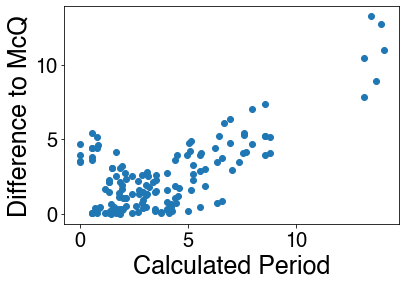

In [14]:
plt.scatter(exo_thirty[0:146], diff_thirty)
plt.ylabel('Difference to McQ')
plt.xlabel('Calculated Period')

In [98]:
thirty_m_large_diff, mcq_large_diff, exo_per = [], [], []

for each, difference in enumerate(diff_thirty):
    if difference > 2.5:
        thirty_m_large_diff.append(tess_30m[each])
        
        tiz = tess_30m[each][3:]
        index = np.where(np.array(tics_short_periods) == np.int(tiz))
        mcq_period = short_periods[index[0][0]]
        
        mcq_large_diff.append(mcq_period)
        exo_per.append(exo_thirty[each])

# two m cadence

In [16]:
with open('two_m.data', 'rb') as filehandle:
    two_m = pickle.load(filehandle) 

with open('tess_2m.data', 'rb') as filehandle:
    tess_2m = pickle.load(filehandle)

In [17]:
len(tess_2m)

38

In [18]:
with open('exo_two.data', 'rb') as filehandle:
    exo_two = pickle.load(filehandle)

In [19]:
diff_two = []
for each, per in enumerate(exo_two):
    tic = tess_2m[each]
    index = np.where(np.array(tics_short_periods) == tic)
    mcq_period = short_periods[index[0][0]]

    diff = np.abs(per - mcq_period)
    diff_two.append(diff)

Text(0.5, 0, 'Calculated Period')

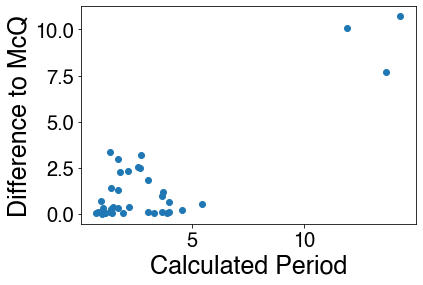

In [20]:
plt.scatter(exo_two, diff_two)
plt.ylabel('Difference to McQ')
plt.xlabel('Calculated Period')

In [21]:
two_m_large_diff = []
for each, difference in enumerate(diff_two):
    if difference > 1.5:
        two_m_large_diff.append(two_m[each])

In [22]:
with open('two_m_large_diff.data', 'wb') as filehandle:
    pickle.dump(two_m_large_diff, filehandle)  

In [74]:
diff_2, diff_30  = [], []
print('McQ ', 'TIC     ', '2m  ', '30m')
for index, each in enumerate(tess_2m):
    for ind, every in enumerate(tess_30m):
        if int(every[3:]) == each: 
            indx = np.where(np.array(tics_short_periods) == each)
            mcq_period = short_periods[indx[0][0]]
            print(mcq_period, each, round(np.array(exo_two)[index],2), round(exo_thirty[ind],2))
            
            difference = np.abs(round(np.array(exo_two)[index] - mcq_period, 2))
            difference_30 = np.abs(round(exo_thirty[ind] - mcq_period, 2))

            diff_2.append(difference)
            diff_30.append(difference_30)

McQ  TIC      2m   30m
2.67 63209318 3.65 5.55
1.37 272596433 1.05 1.35
1.18 159721038 1.15 1.15
1.85 271959015 1.5 1.8
1.45 164652676 1.35 1.45
2.78 272598447 1.4 1.35
3.15 424865046 3.05 3.45
2.99 270696609 1.7 5.25
1.03 120693506 1.05 2.1
1.84 120963587 11.9 1.85
5.98 270619467 13.65 5.55
4.64 164413746 4.0 8.55
4.49 273374778 2.15 2.15
4.7 267745242 1.7 0
2.0 164670606 1.7 2.9
4.36 27773745 4.55 0.55
3.34 399867682 3.3 8.55
2.0 123201168 1.95 5.25
1.52 121327452 1.45 1.85
4.89 270696968 3.05 2.7
0.78 27843903 0.75 4.4
4.73 158317151 1.35 8.8
3.6 164778770 14.3 2.85
4.09 123230837 4.0 7.05
4.89 121456902 5.45 1.85
2.57 121123220 2.2 4.4
1.67 298787492 1.4 1.95
0.99 377782358 1.0 4.95
5.15 122447460 2.6 1.95
5.17 27911635 2.7 4.45
0.9 351910775 0.8 3.5
5.93 120765034 2.75 3.1
2.51 27006972 3.7 2.95
3.93 271355239 3.9 0
1.22 272272592 1.15 6.45
4.07 270705470 1.8 4.25
3.56 122300184 3.65 7.7
0.26 123414877 0.95 2.85


2 min cadence tended to be closer to the McQuillan period

# eleanor

In [29]:
star = eleanor.Source(tic=38846515)
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)
q = data.quality == 0

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]




100%|██████████| 1320/1320 [00:29<00:00, 44.21it/s]


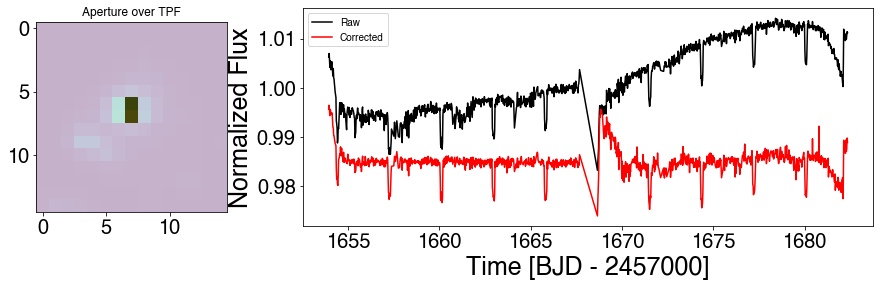

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})

ax1.imshow(data.tpf[0])
ax1.imshow(data.all_apertures[0], cmap='Greys', alpha=0.7)
ax1.set_title('Aperture over TPF')

ax2.plot(data.time[q], data.all_raw_flux[0][q]/np.nanmedian(data.all_raw_flux[0][q]), 'k', label='Raw')
ax2.plot(data.time[q], data.all_corr_flux[0][q]/np.nanmedian(data.all_corr_flux[0][q]) - 0.015, 'r', label='Corrected')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux')
ax2.legend();

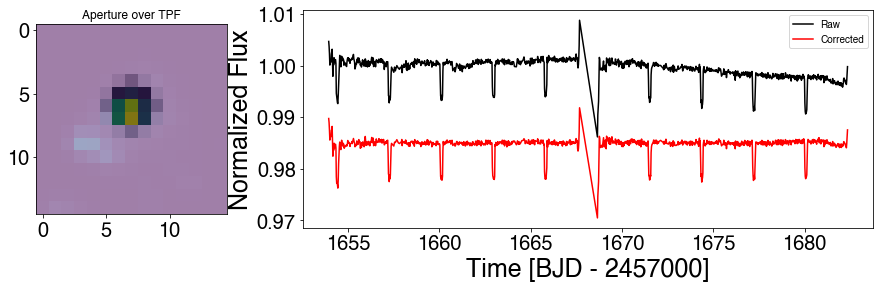

In [47]:
eleanor.TargetData.custom_aperture(data, shape='circle', r=2, pos=[7,6], method='exact')
eleanor.TargetData.get_lightcurve(data)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.015, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

# thirty min cadence with large differences from McQuillan

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:35<00:00, 35.04it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:44<00:00, 26.80it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:38<00:00, 31.29it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:38<00:00, 31.40it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:52<00:00, 22.62it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:36<00:00, 33.20it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [05:11<00:00,  3.84it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:25<00:00, 49.44it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:19<00:00, 60.67it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:18<00:00, 65.75it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:22<00:00, 54.42it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:26<00:00, 45.39it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:31<00:00, 39.21it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:32<00:00, 36.33it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:31<00:00, 39.09it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:34<00:00, 34.88it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:32<00:00, 36.72it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:34<00:00, 36.20it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:35<00:00, 33.96it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:32<00:00, 37.04it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:29<00:00, 41.58it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:31<00:00, 39.79it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:20<00:00, 58.38it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:36<00:00, 33.88it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:22<00:00, 52.87it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:23<00:00, 52.70it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:25<00:00, 48.28it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1121/1121 [00:20<00:00, 54.04it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:28<00:00, 44.05it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:43<00:00, 28.51it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:43<00:00, 28.38it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [01:05<00:00, 18.97it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:37<00:00, 32.22it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:31<00:00, 39.04it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:27<00:00, 43.57it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:30<00:00, 40.34it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:39<00:00, 31.28it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:34<00:00, 35.94it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:57<00:00, 21.58it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:32<00:00, 36.69it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:56<00:00, 22.16it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:49<00:00, 24.97it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:39<00:00, 31.12it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:47<00:00, 25.25it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:31<00:00, 39.35it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:34<00:00, 34.90it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:34<00:00, 35.72it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:31<00:00, 37.42it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:38<00:00, 31.33it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:40<00:00, 29.22it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:39<00:00, 30.25it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:35<00:00, 35.33it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:37<00:00, 32.03it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:53<00:00, 23.30it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [01:00<00:00, 19.75it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1197/1197 [00:51<00:00, 23.07it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:44<00:00, 27.72it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:34<00:00, 35.06it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:48<00:00, 24.80it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:44<00:00, 27.94it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:45<00:00, 27.28it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:40<00:00, 30.90it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...


100%|██████████| 1241/1241 [00:38<00:00, 32.00it/s]


No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:42<00:00, 28.92it/s]


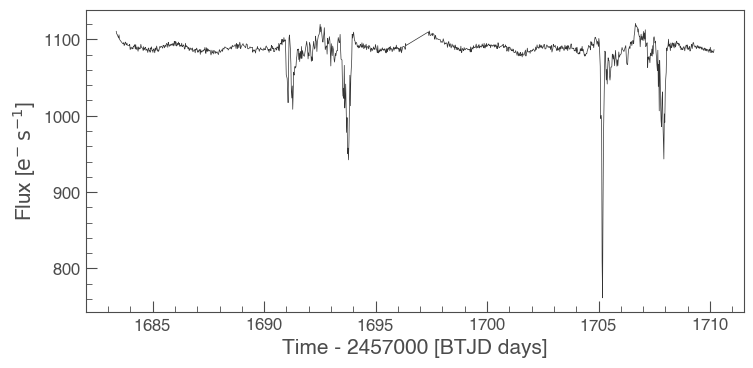

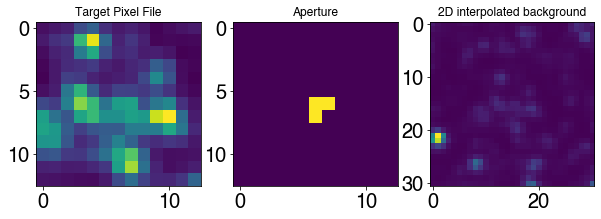

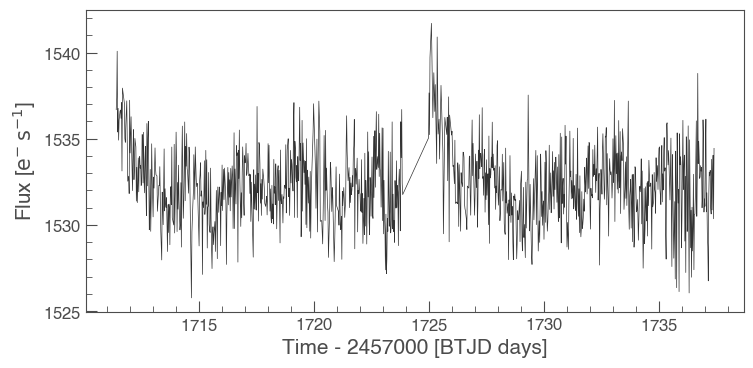

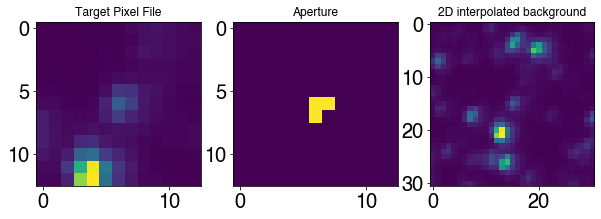

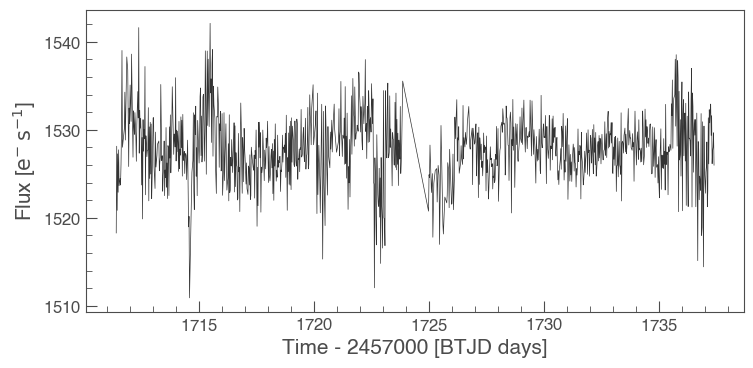

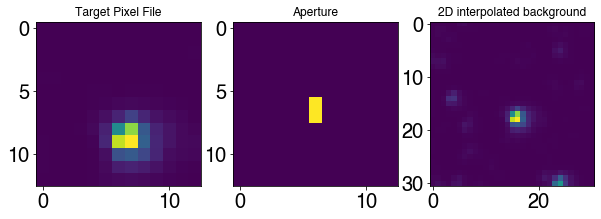

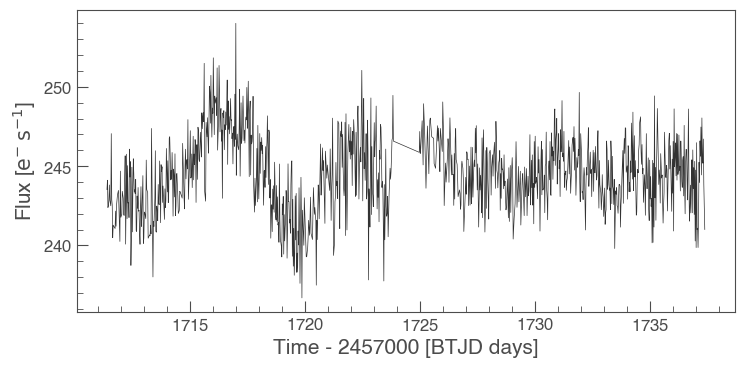

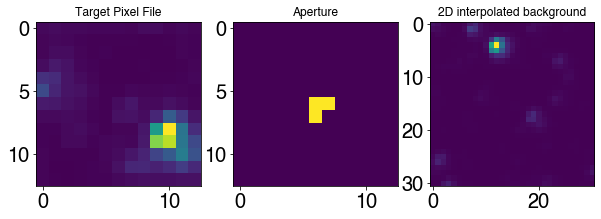

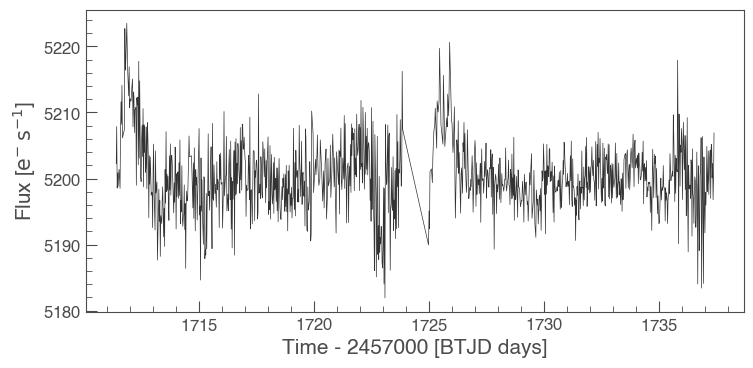

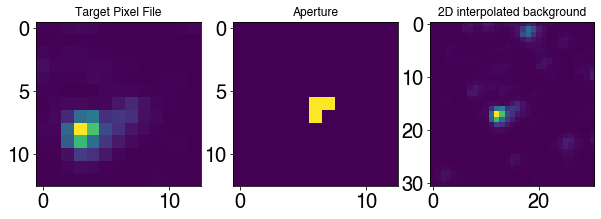

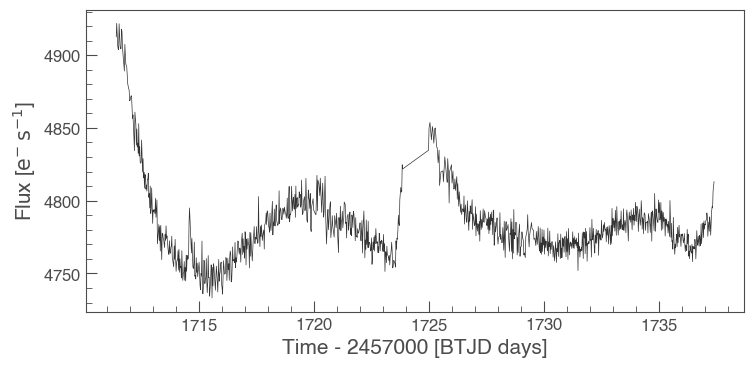

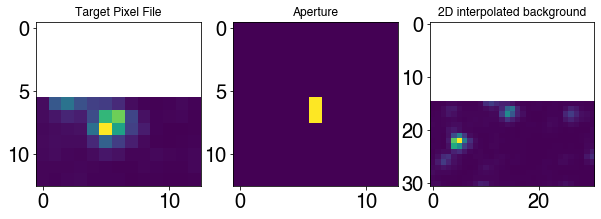

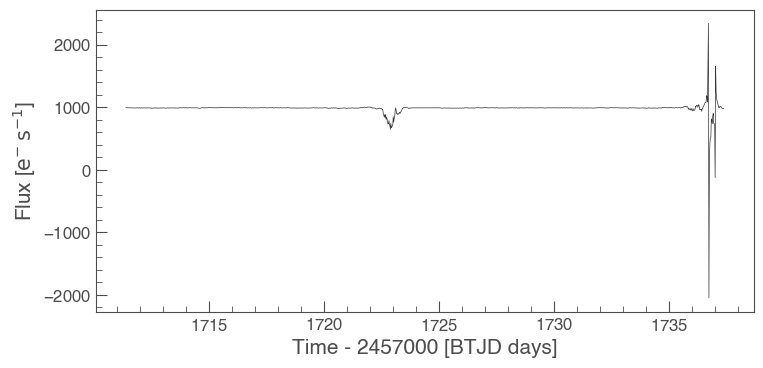

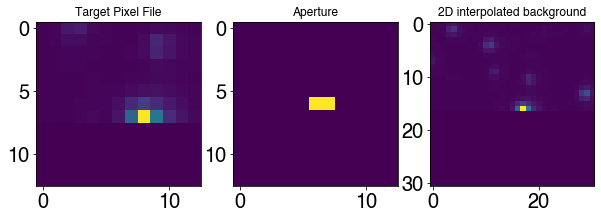

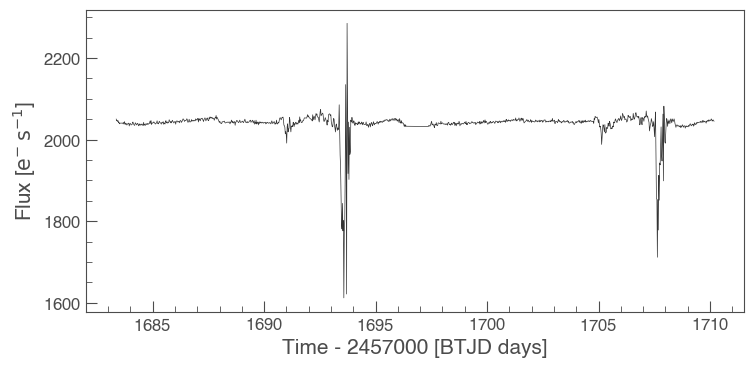

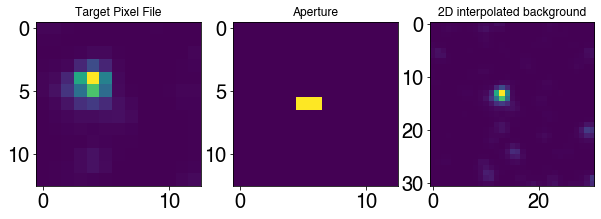

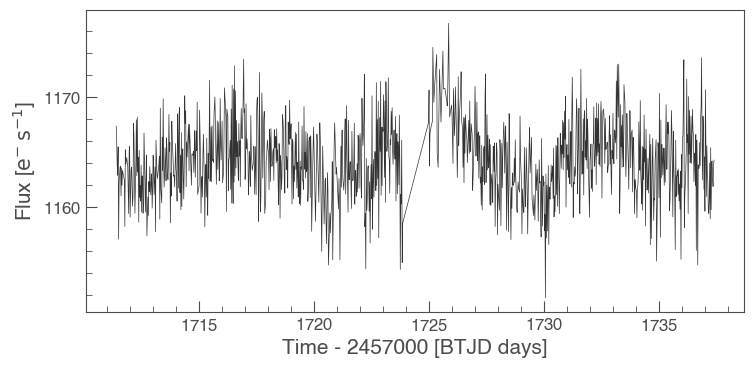

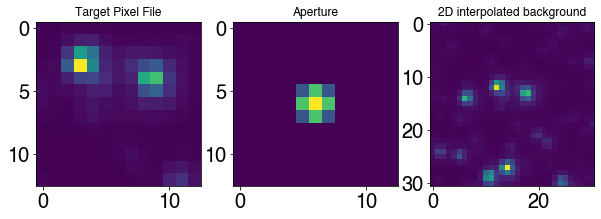

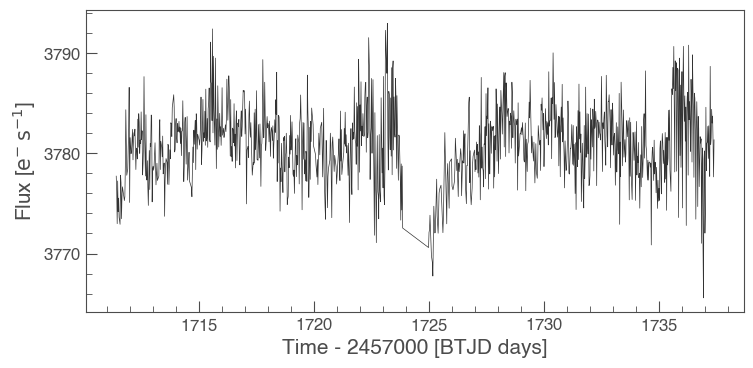

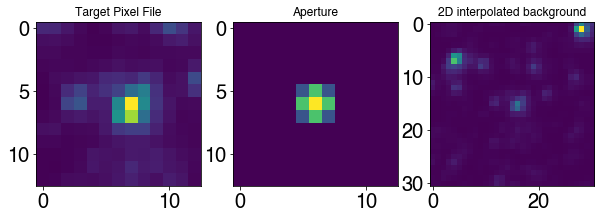

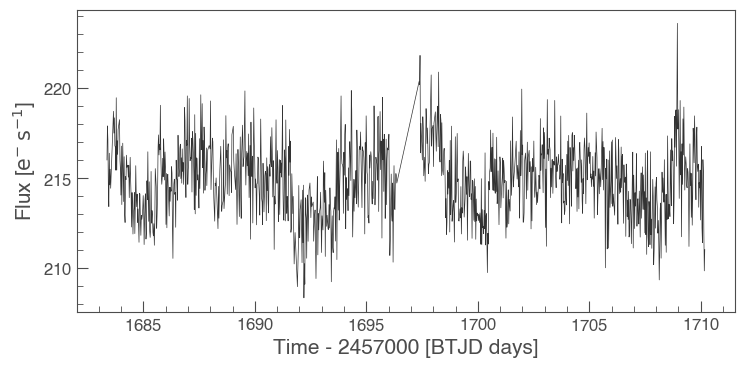

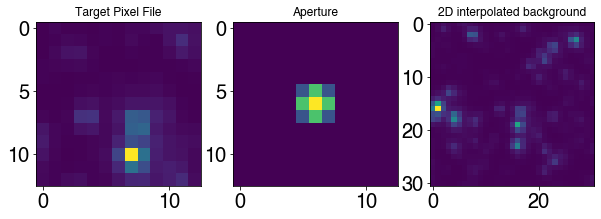

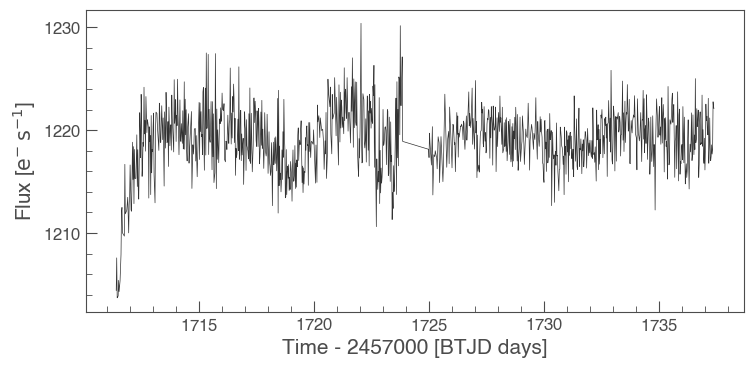

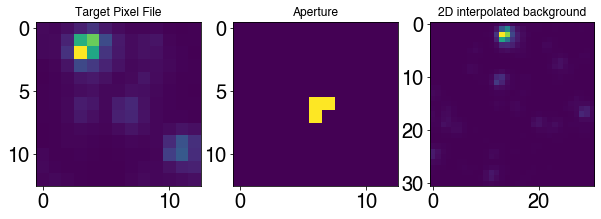

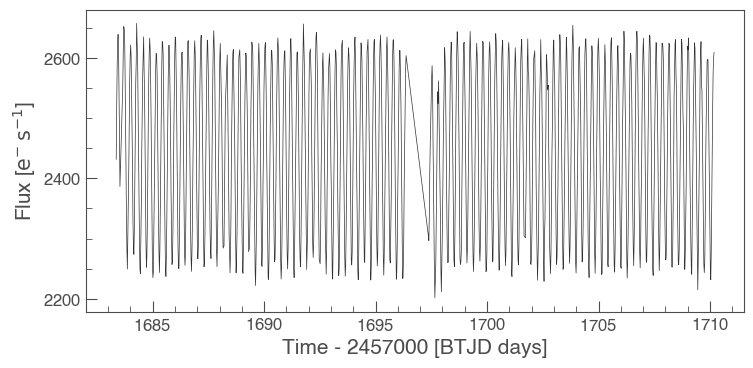

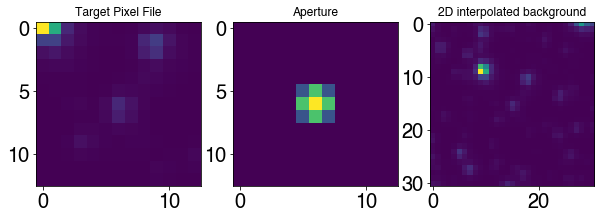

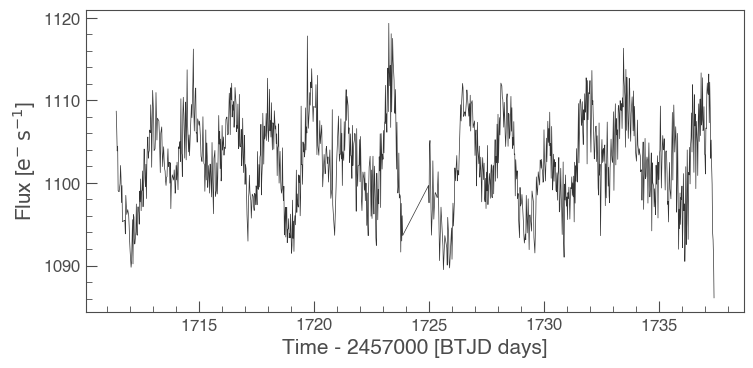

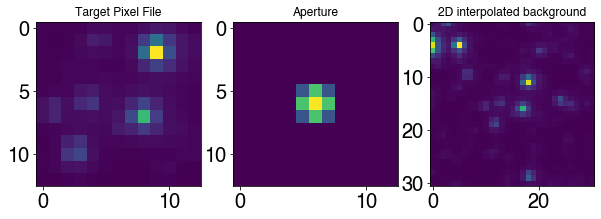

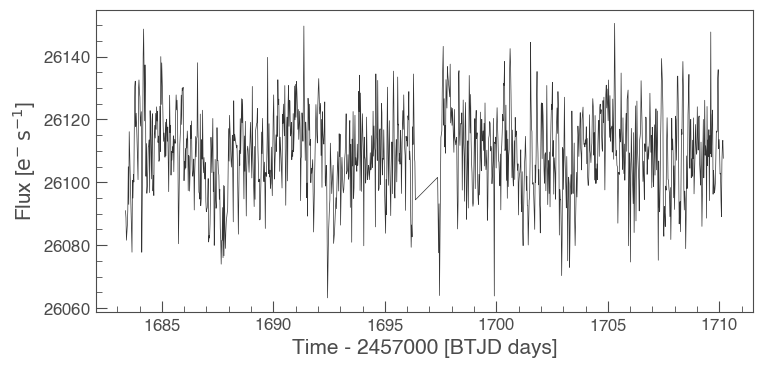

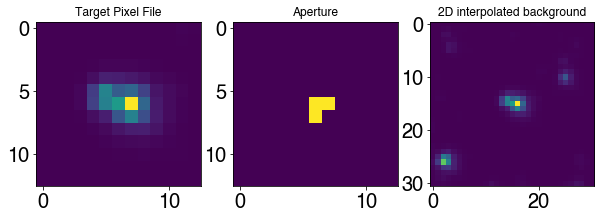

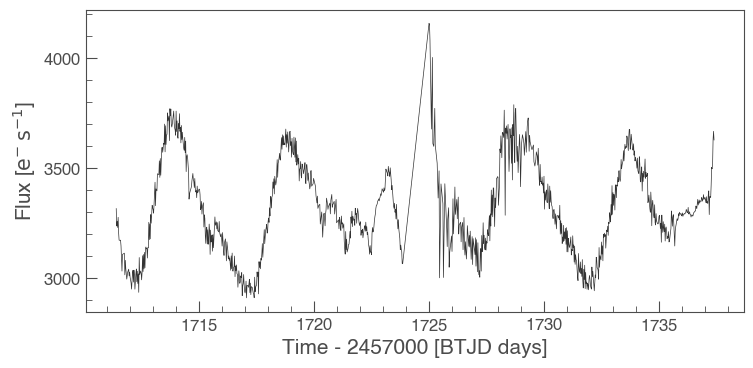

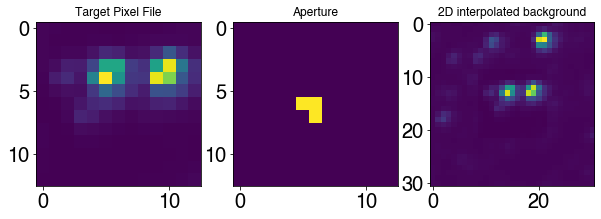

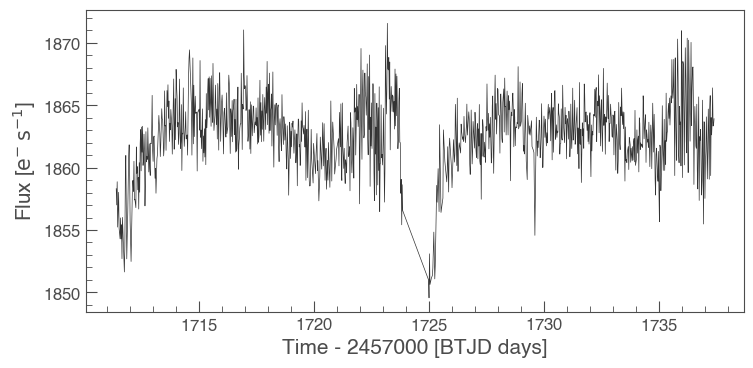

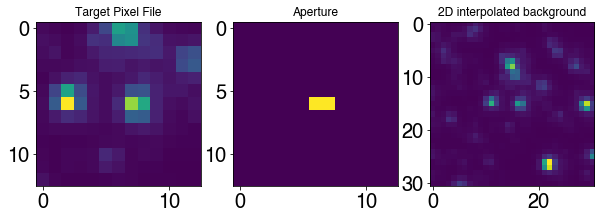

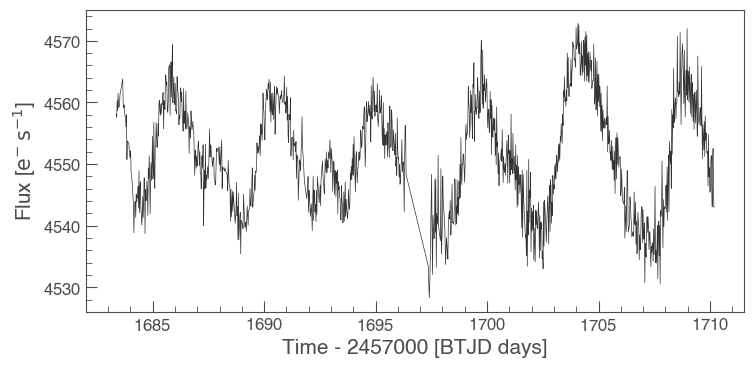

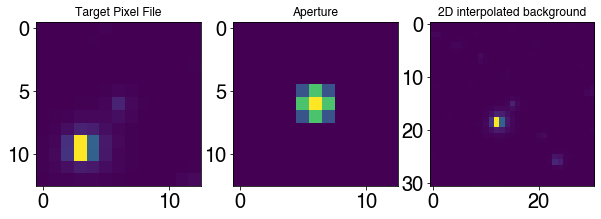

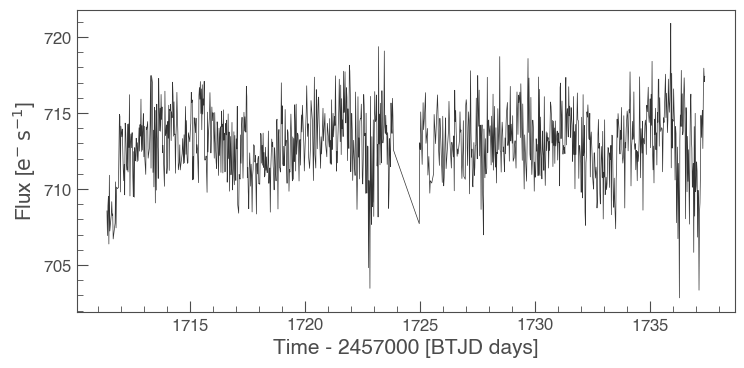

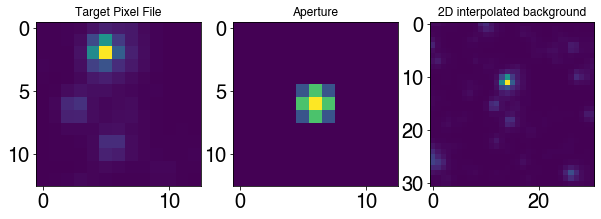

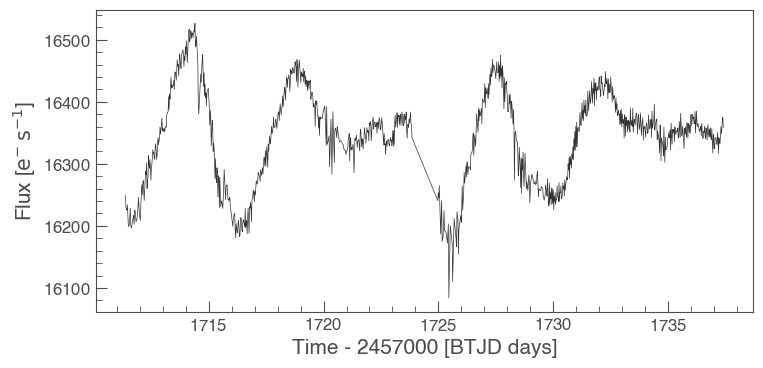

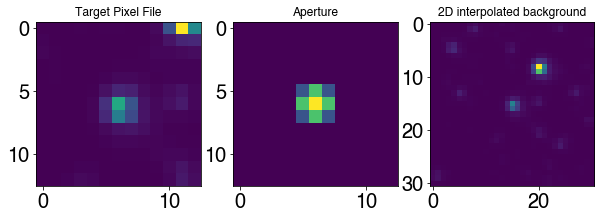

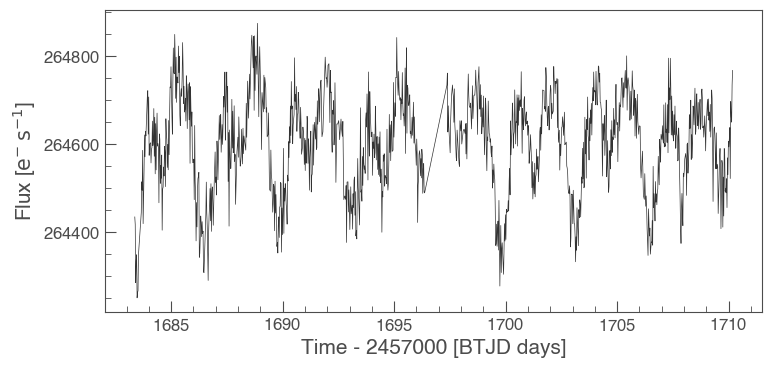

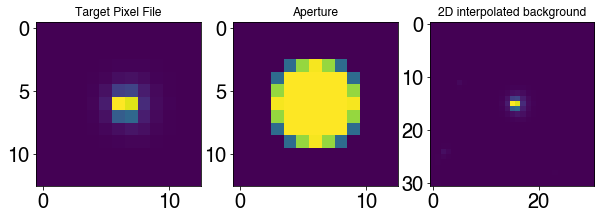

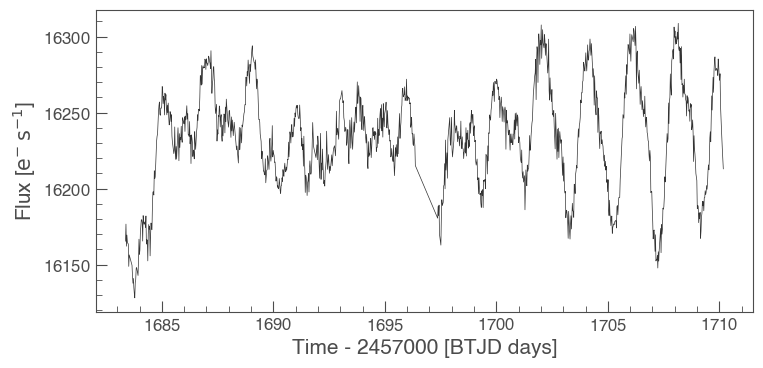

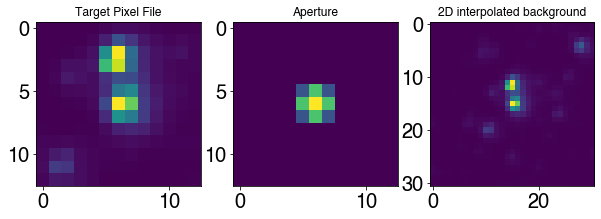

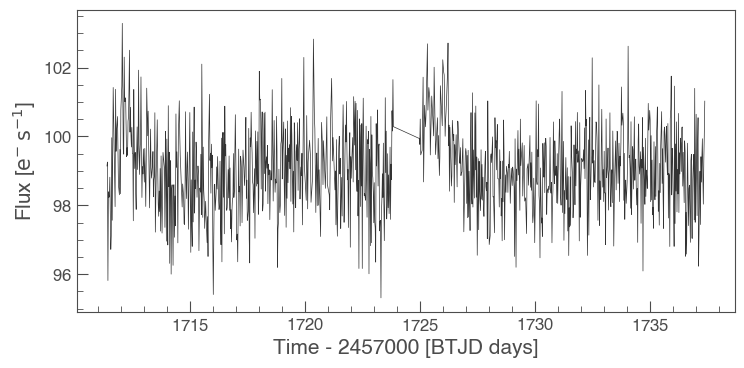

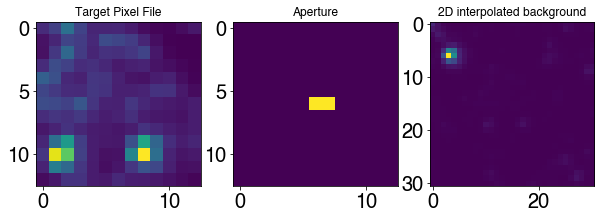

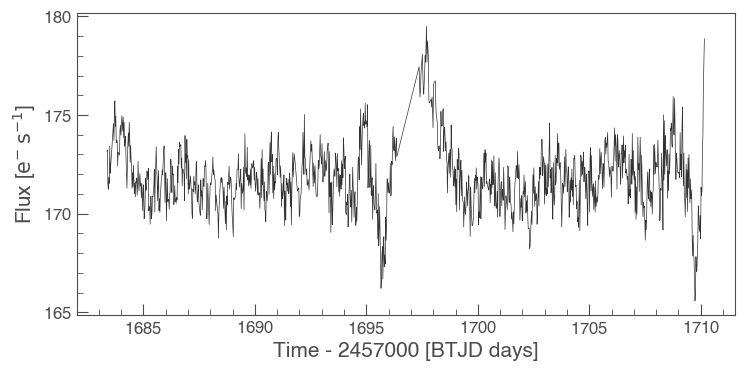

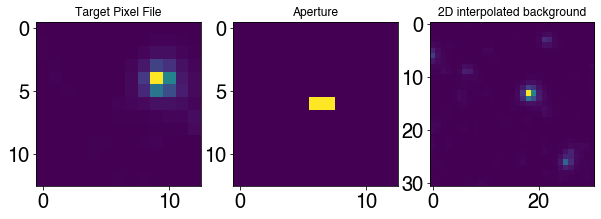

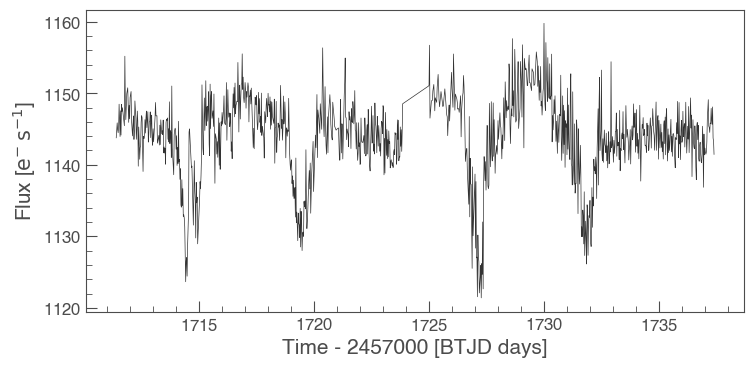

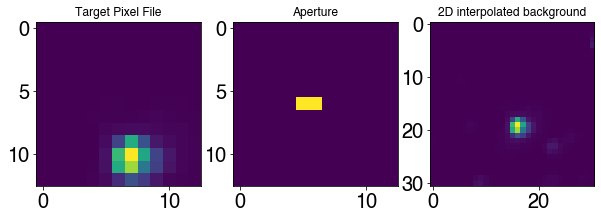

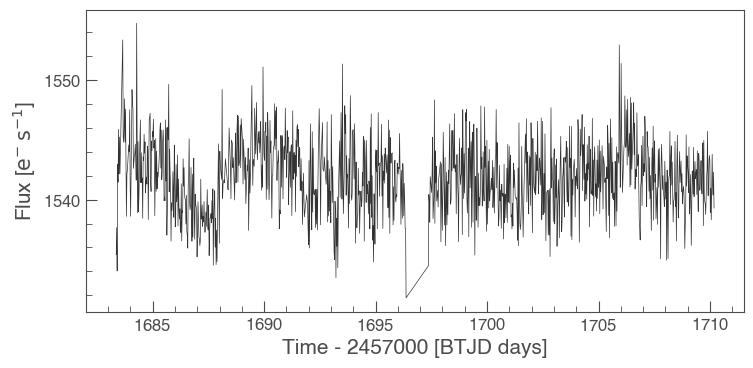

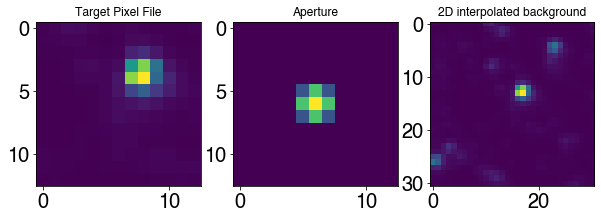

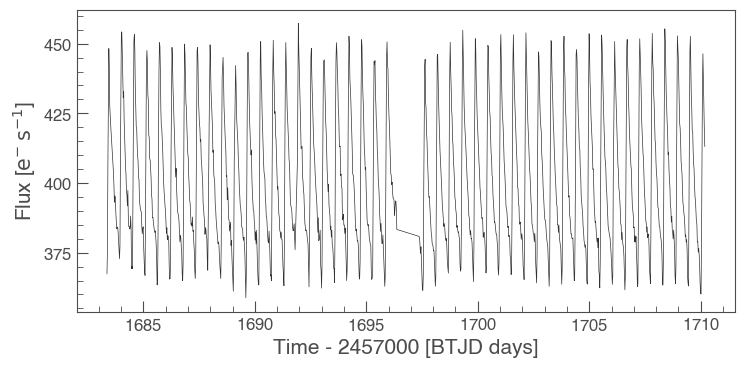

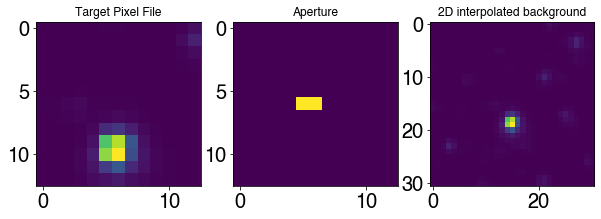

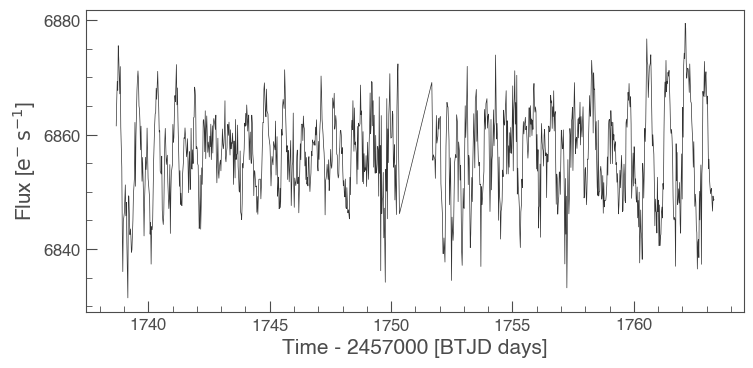

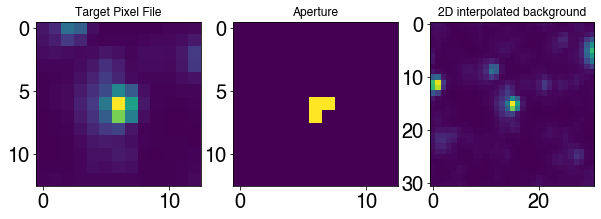

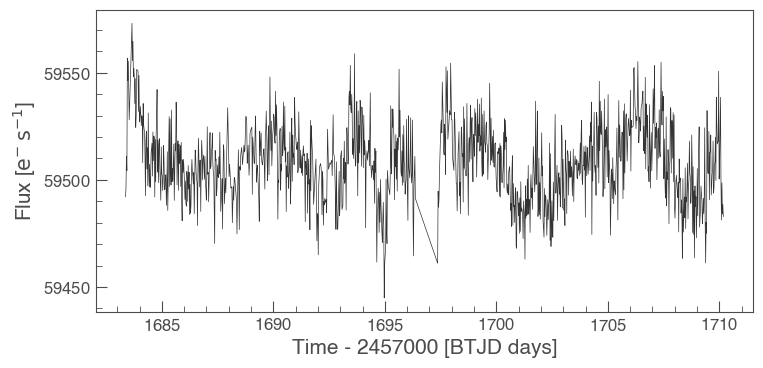

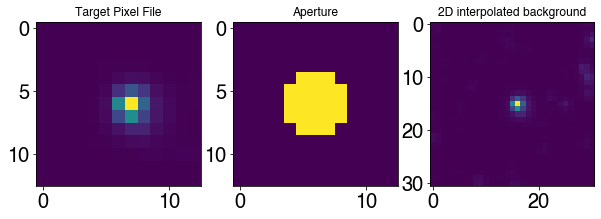

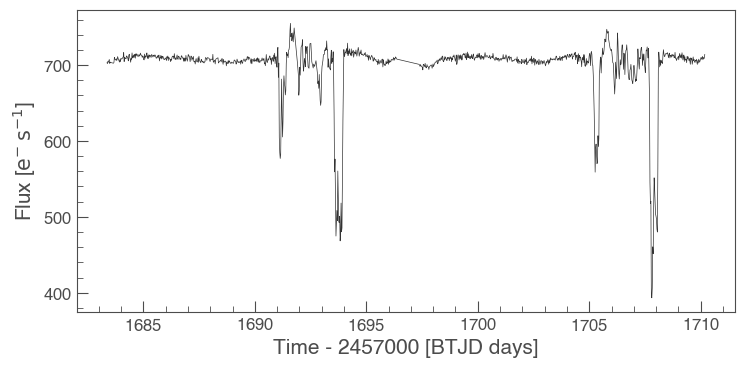

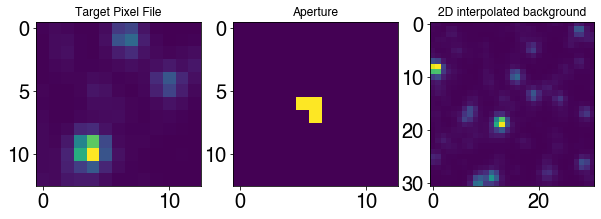

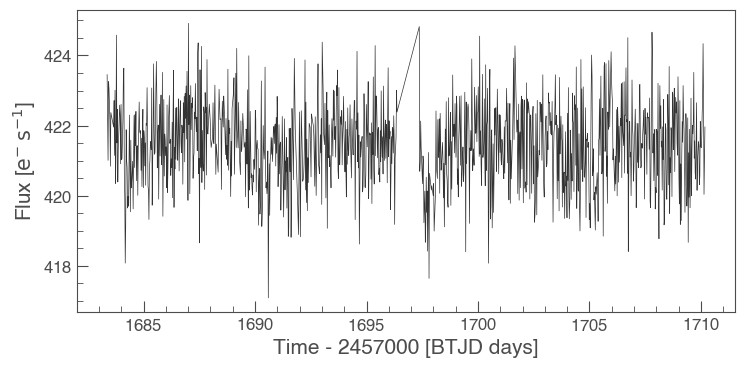

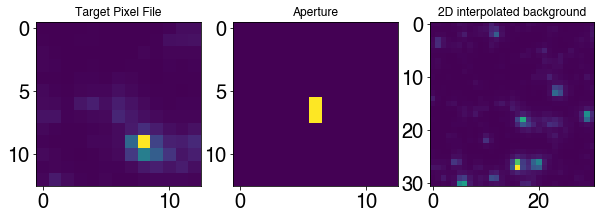

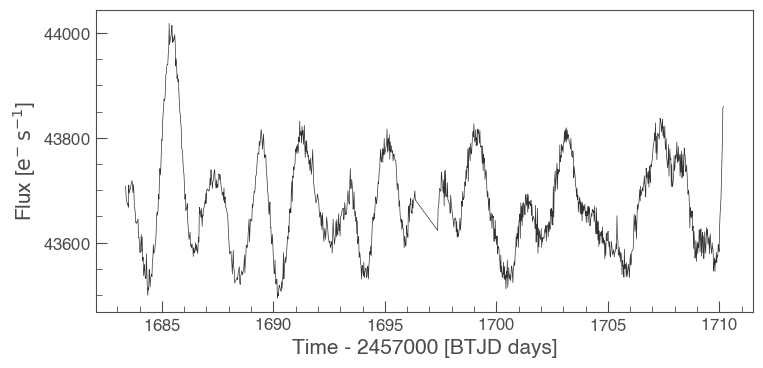

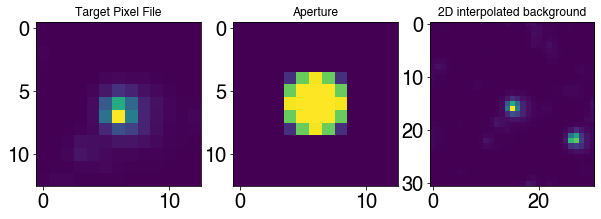

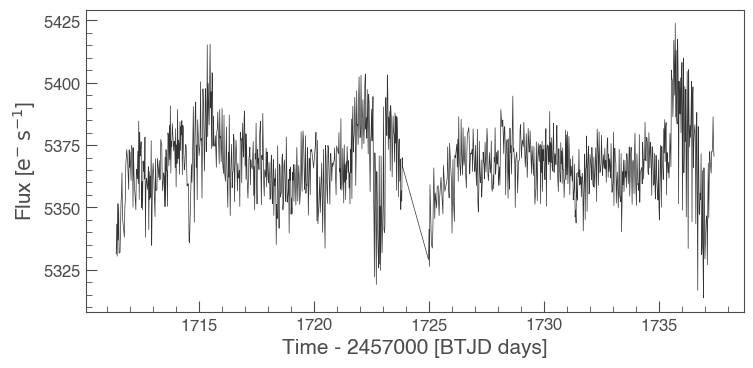

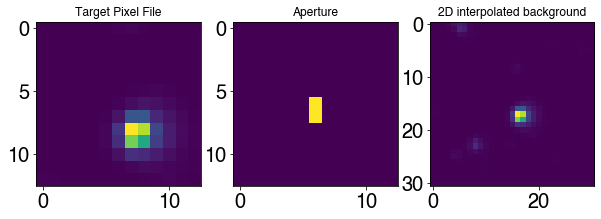

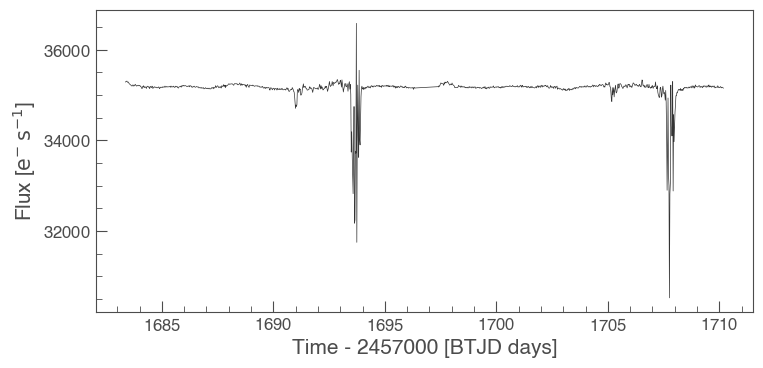

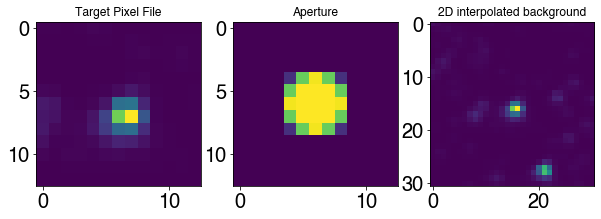

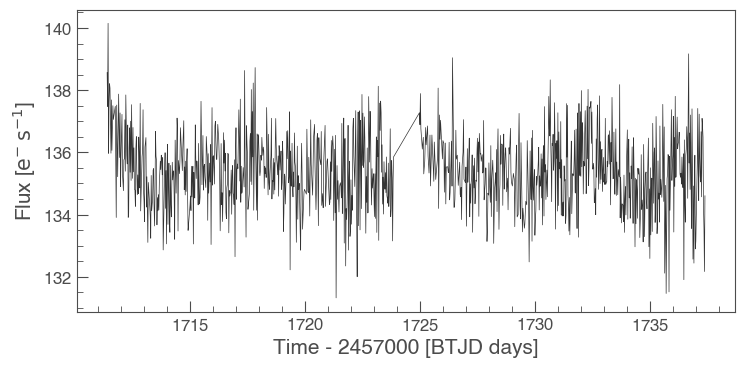

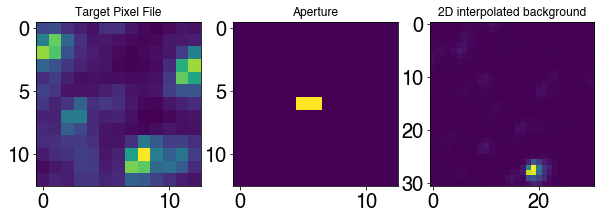

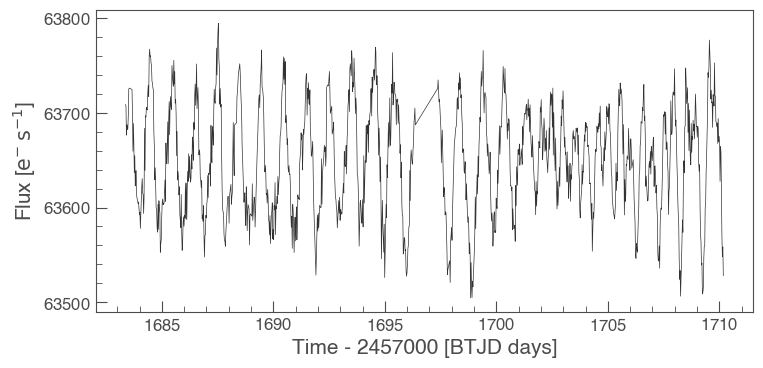

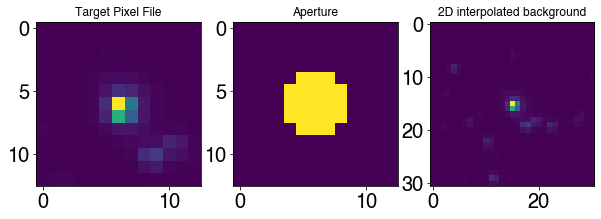

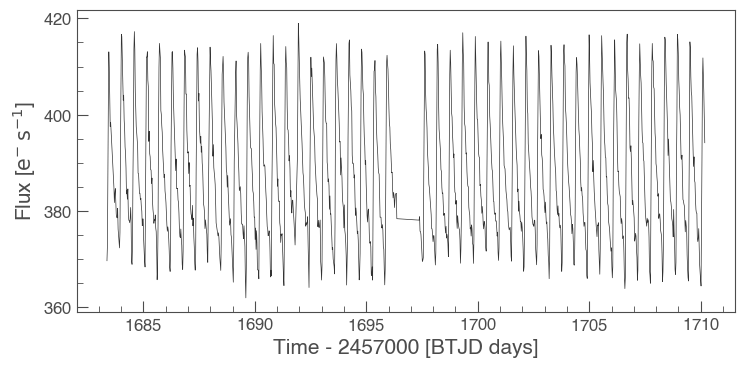

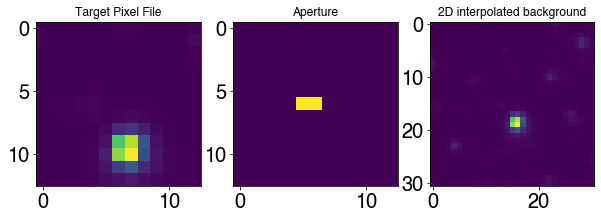

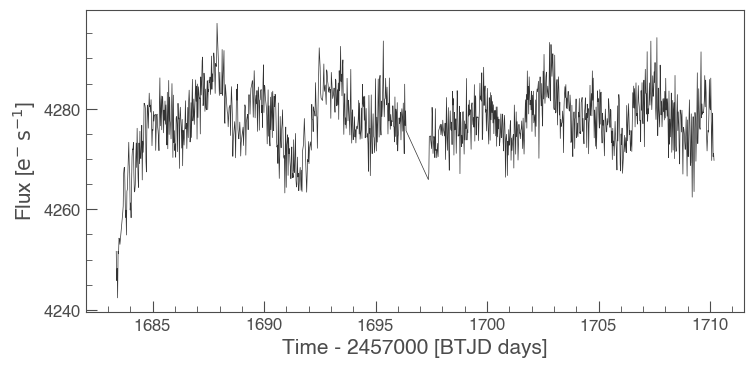

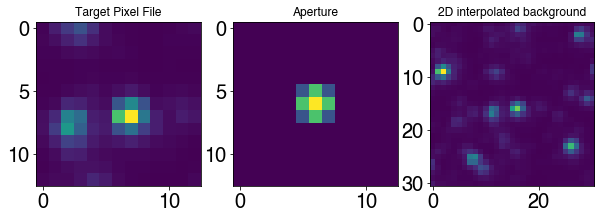

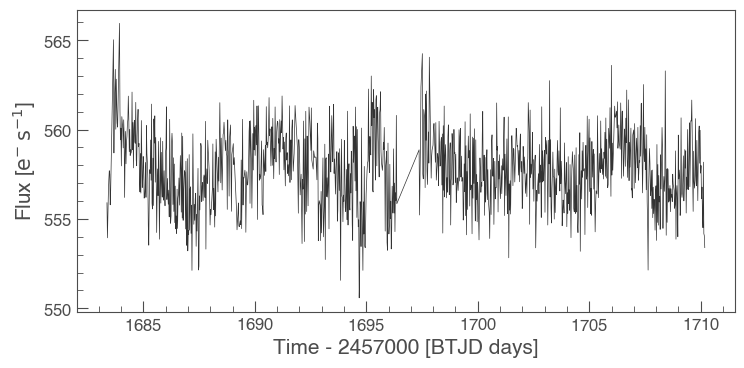

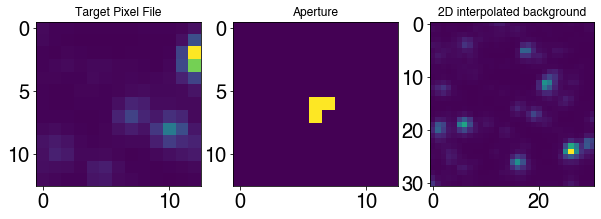

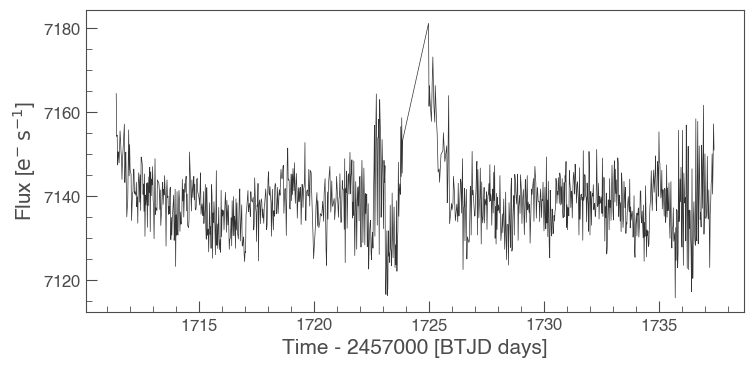

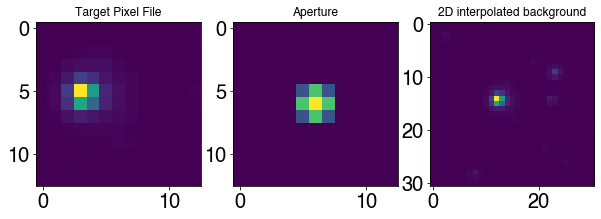

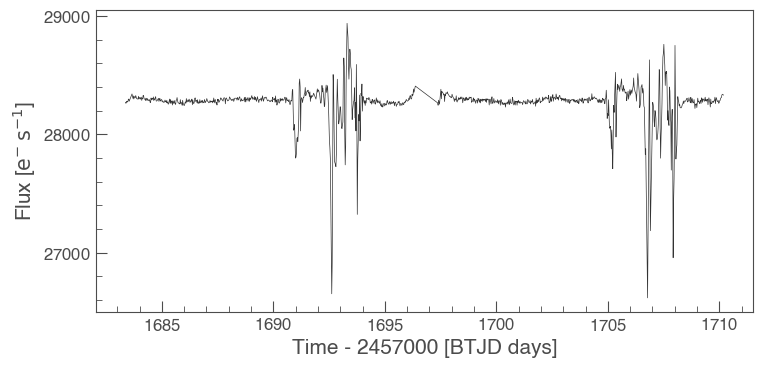

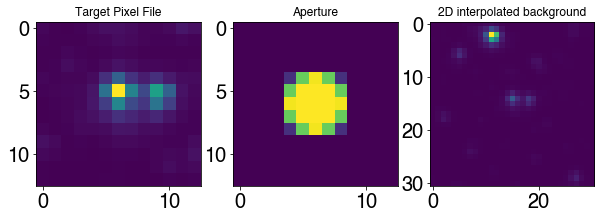

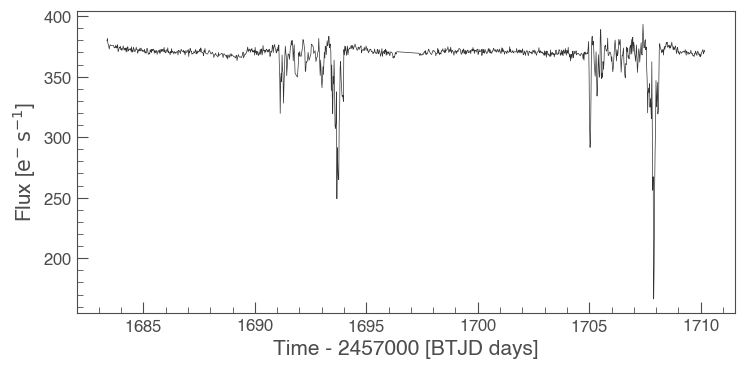

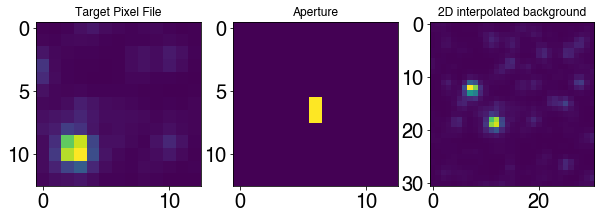

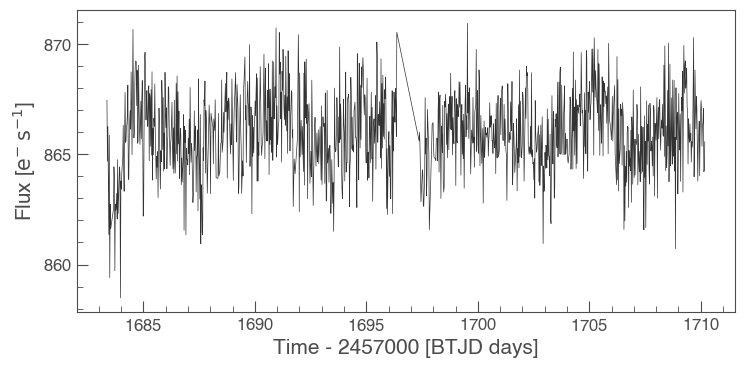

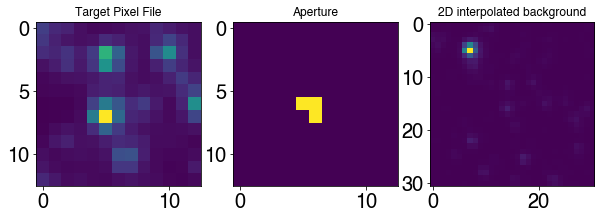

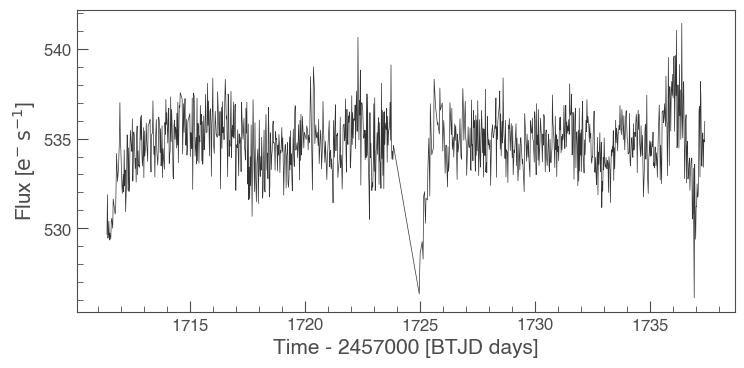

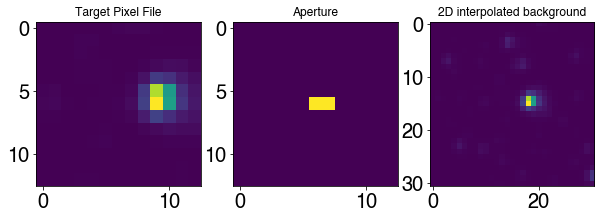

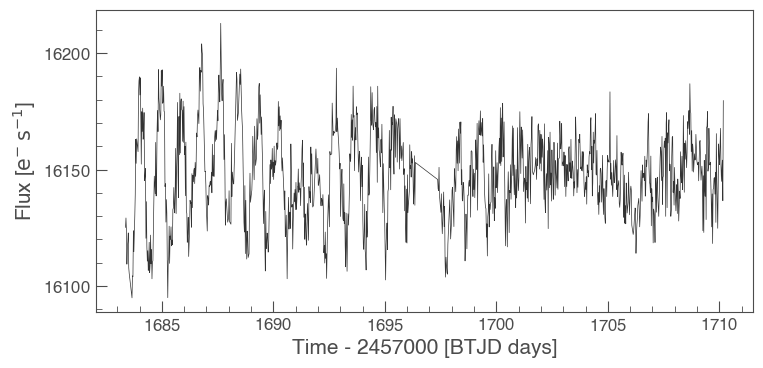

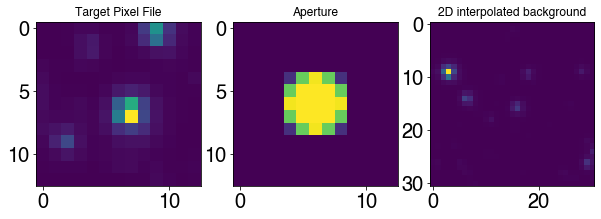

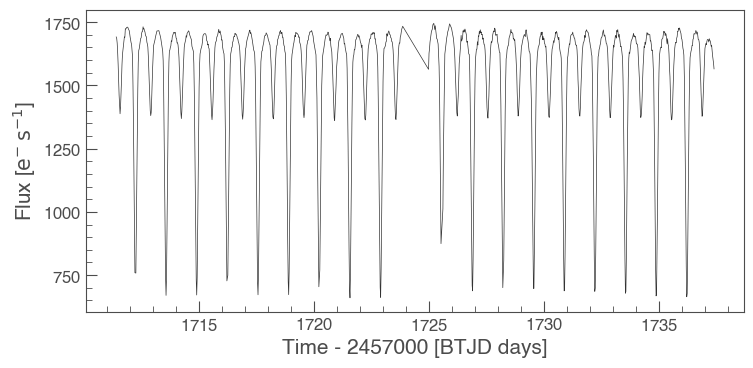

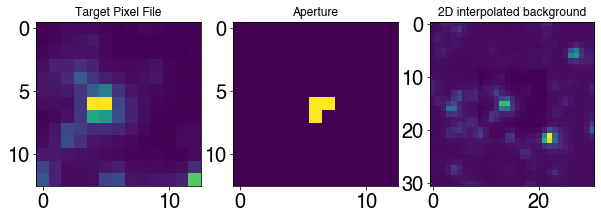

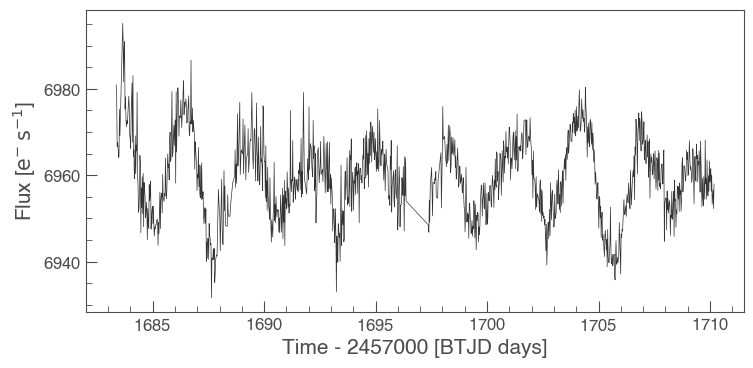

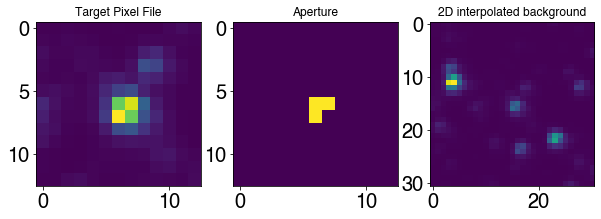

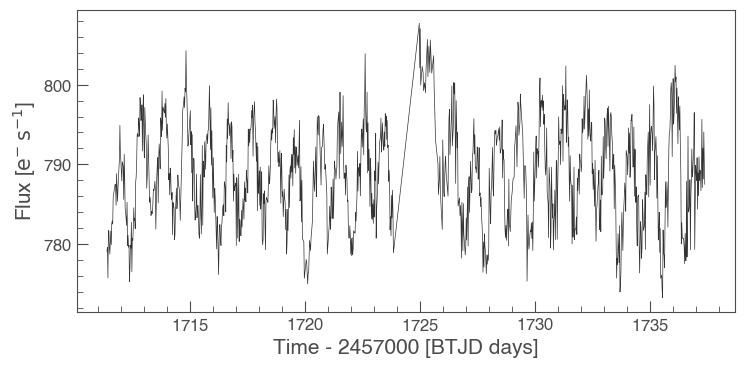

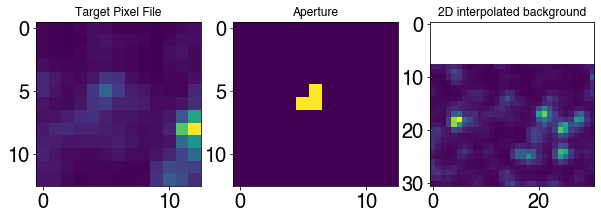

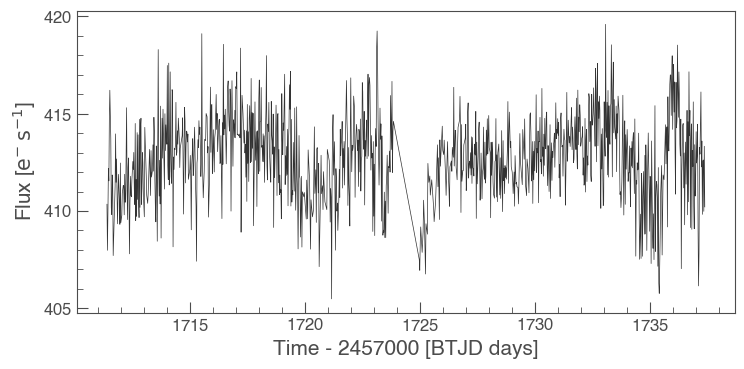

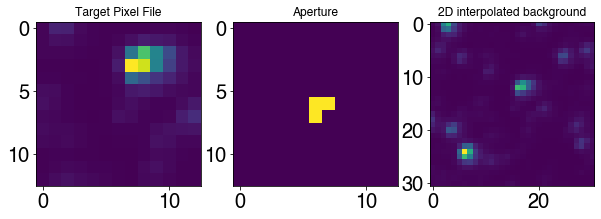

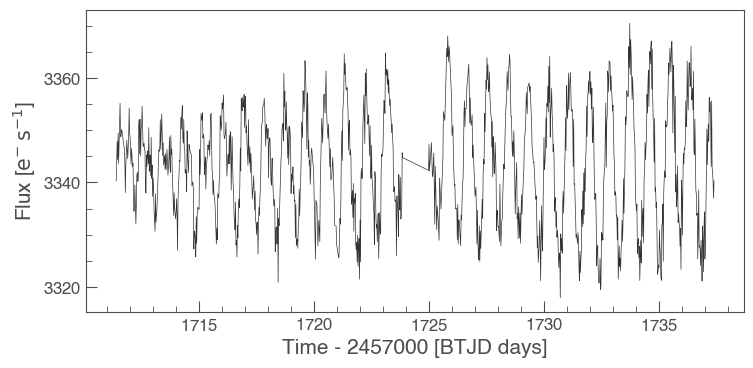

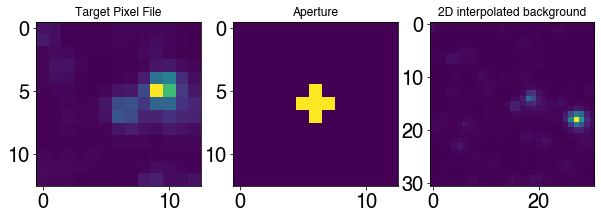

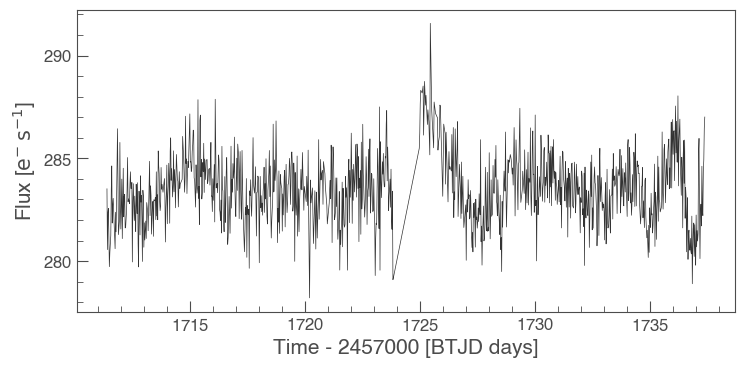

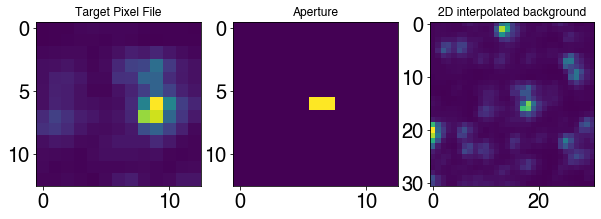

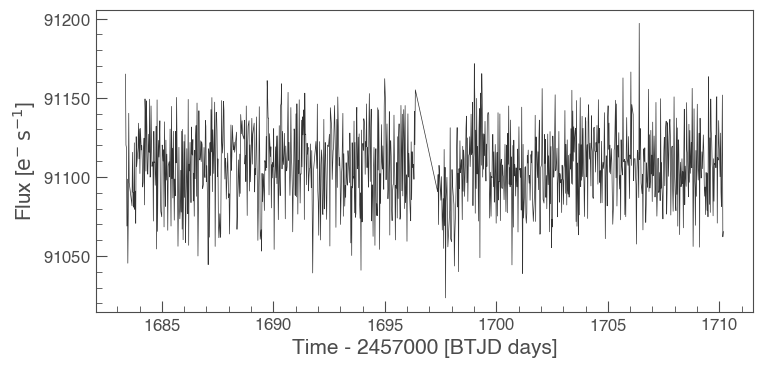

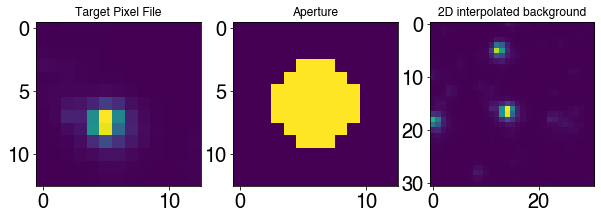

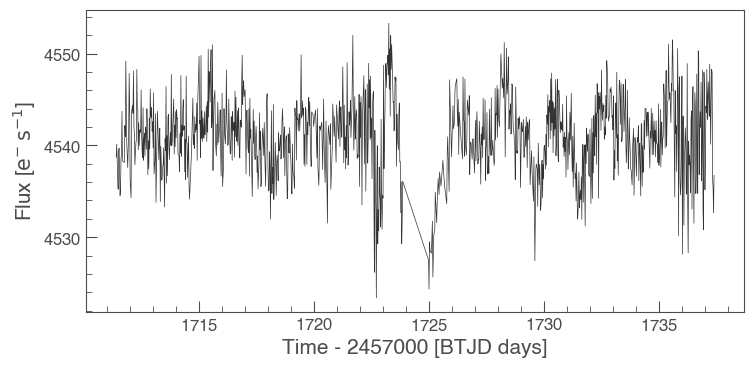

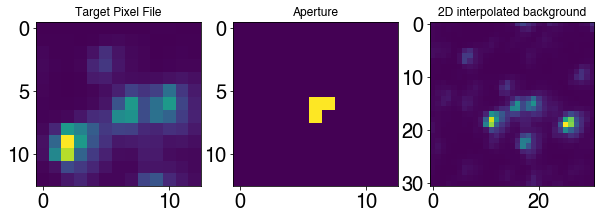

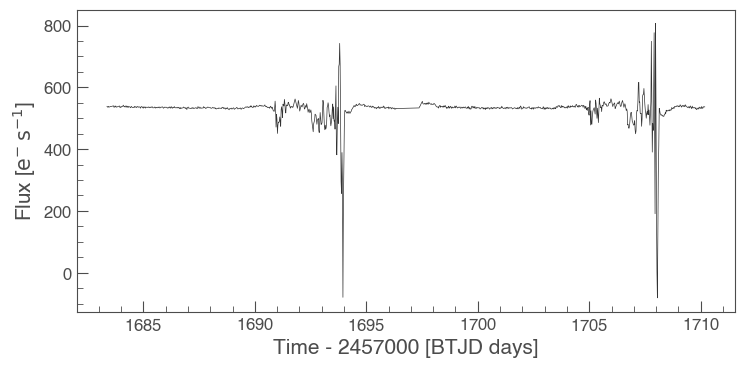

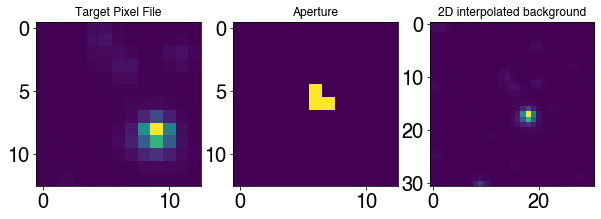

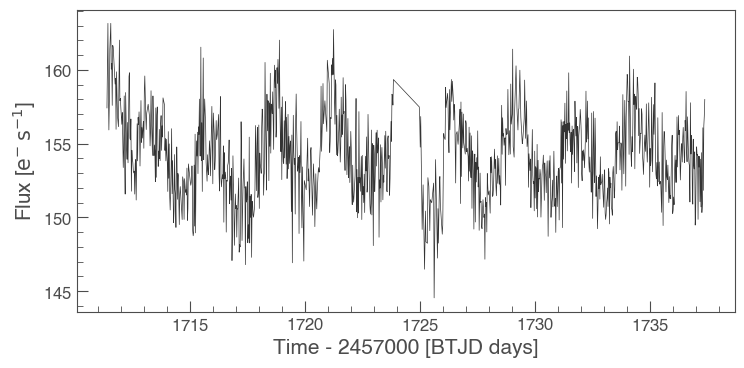

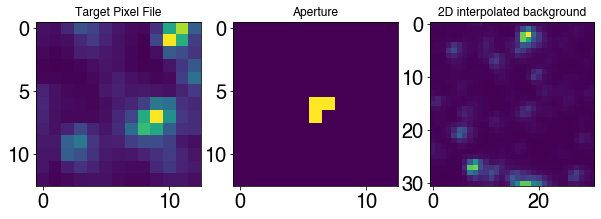

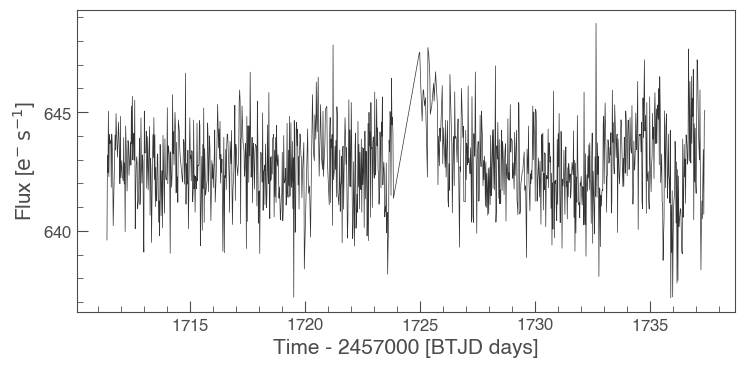

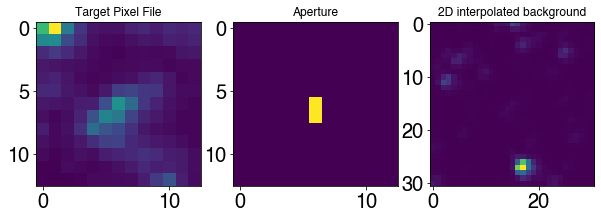

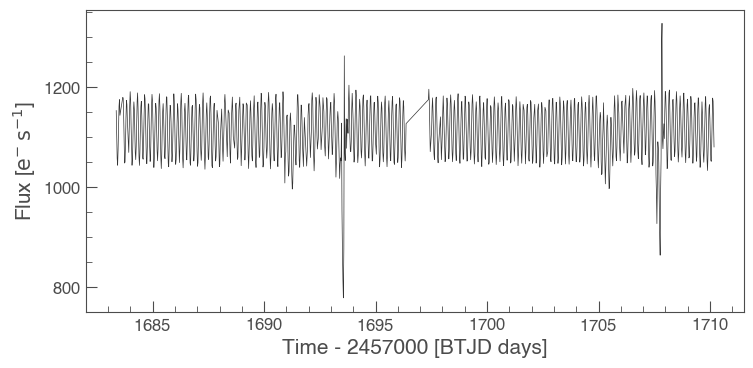

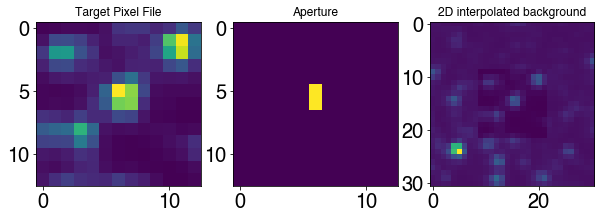

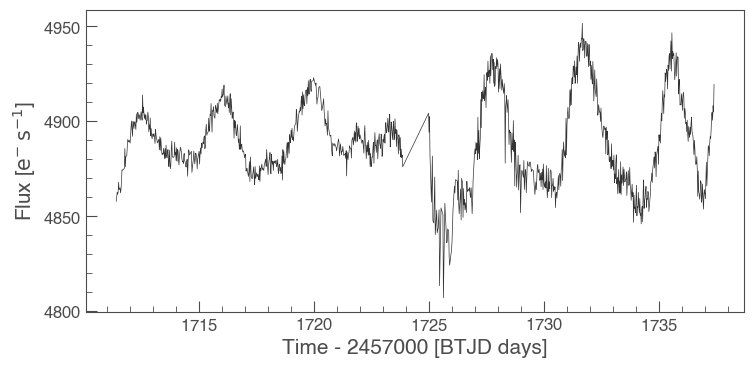

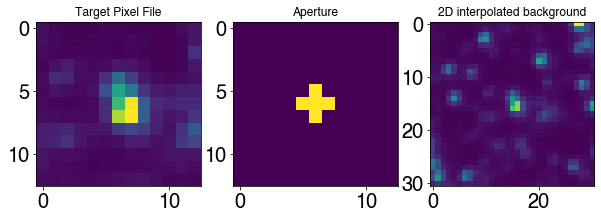

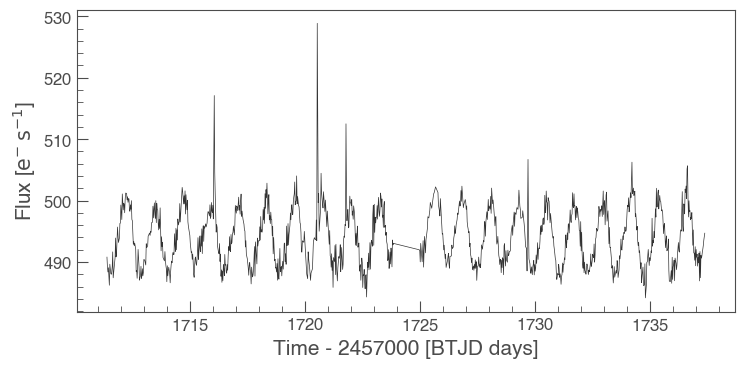

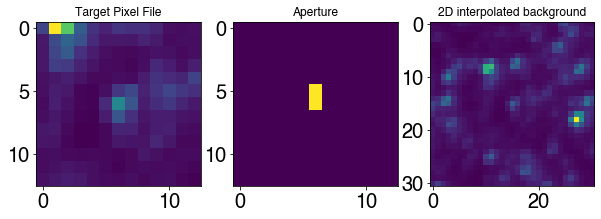

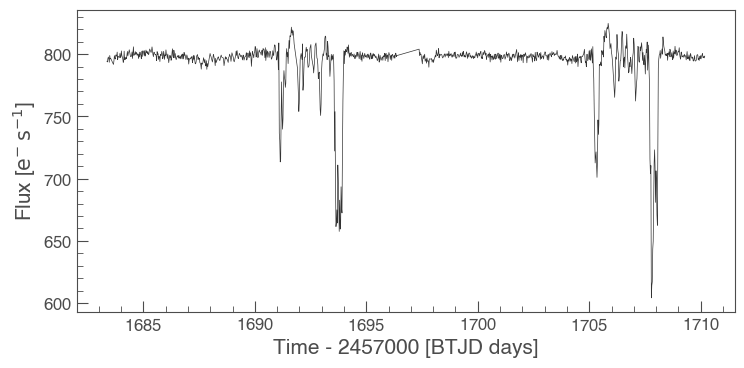

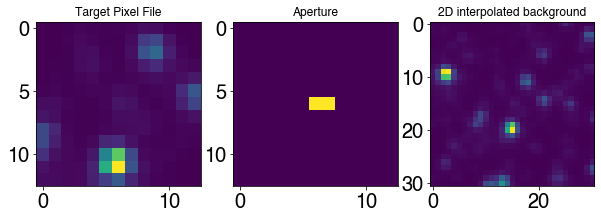

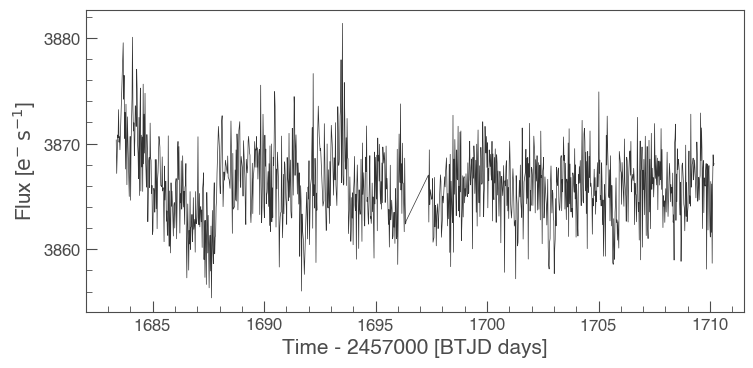

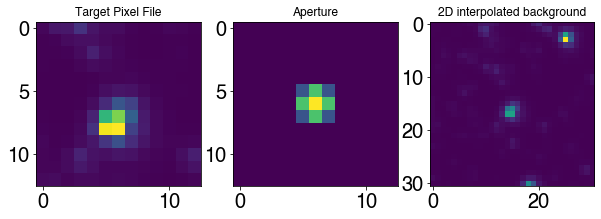

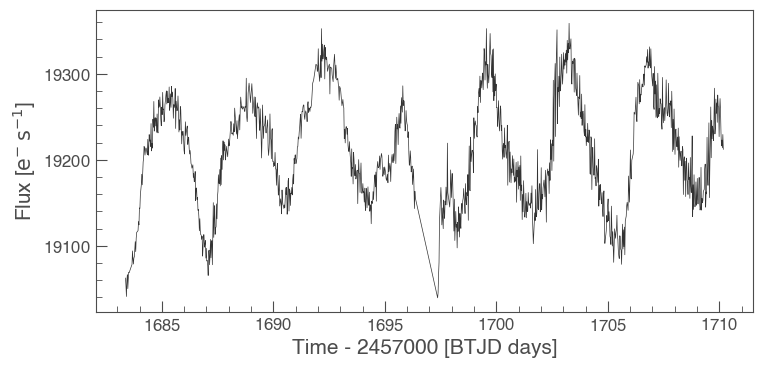

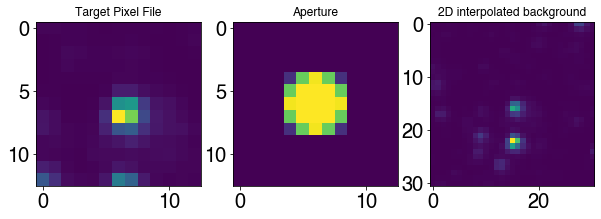

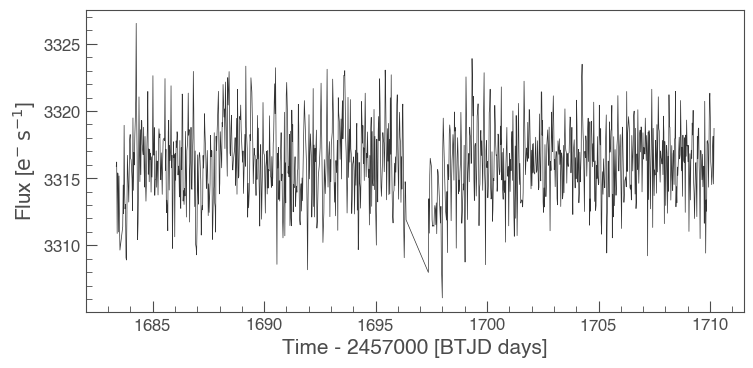

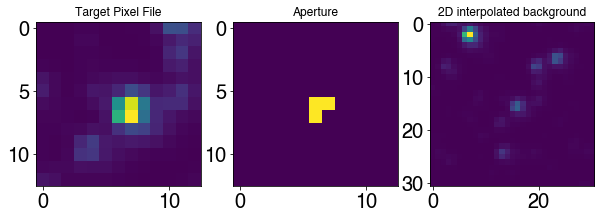

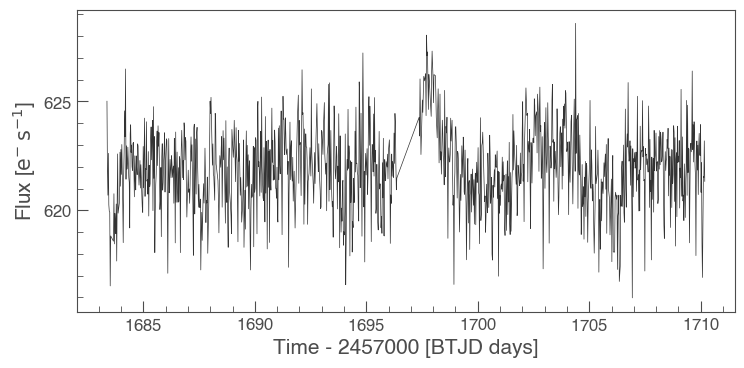

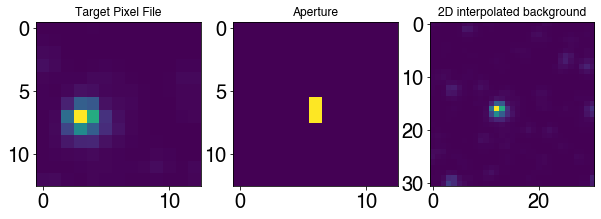

In [57]:
for each, tick in enumerate(thirty_m_large_diff):
    star = eleanor.Source(tic=tick[3:])
    test_star = eleanor.TargetData(star, do_psf = True, do_pca = True)
    lk = test_star.to_lightkurve()
    lk.plot()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,4))
    ax1.imshow(test_star.tpf[0])
    ax1.set_title('Target Pixel File')
    ax2.imshow(test_star.aperture)
    ax2.set_title('Aperture')
    ax3.imshow(test_star.bkg_tpf[0])
    ax3.set_title('2D interpolated background');
    fig.show()

# testing aperture changes - 30m cadences with large difference from McQ

# 0

In [49]:
star_0 = eleanor.Source(tic=171098535)
data_0 = eleanor.TargetData(star_0, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1241/1241 [00:31<00:00, 39.41it/s]


In [104]:
print('McQ Period: ', mcq_large_diff[0])
print('Calculated Period :', exo_per[0])

McQ Period:  2.85
Calculated Period : 6.349999999994225


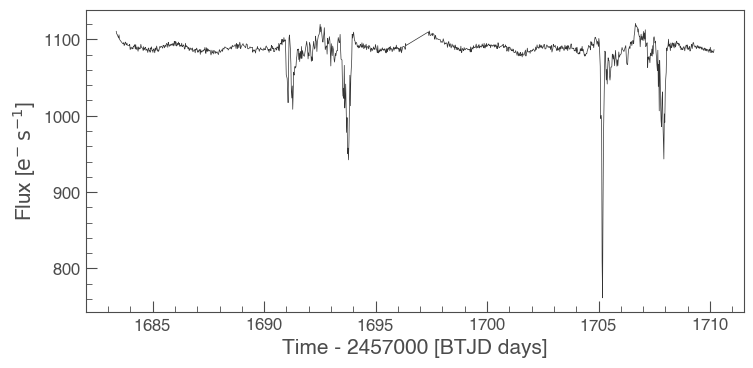

In [51]:
lk_0 = data_0.to_lightkurve()
lk_0.plot()

In [87]:
kep_lc_0 = search_targetpixelfile('TIC 171098535').download(quality_bitmask='default');

In [99]:
kep_lc_0.interact()

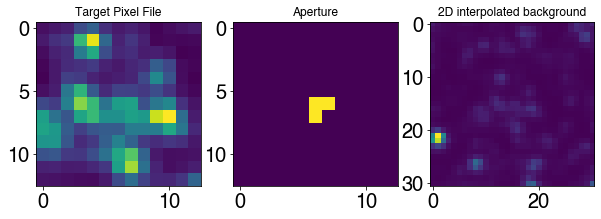

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,4))
ax1.imshow(data_0.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data_0.aperture)
ax2.set_title('Aperture')
ax3.imshow(data_0.bkg_tpf[0])
ax3.set_title('2D interpolated background');

In [91]:
kep_lc_0.interact_sky()

# 1

In [157]:
star_1 = eleanor.Source(tic=63209318)
data_1 = eleanor.TargetData(star_1, do_psf=True, do_pca=True)

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:31<00:00, 37.70it/s]


In [107]:
star_1 = eleanor.Source(tic=63209318)
data_1 = eleanor.TargetData(star_1, do_psf=True, do_pca=True)
q = data_1.quality == 0

print('McQ Period: ', mcq_large_diff[1])
print('Calculated Period :', exo_per[1])

kep_lc_1 = search_targetpixelfile('TIC 63209318').download(quality_bitmask='default');
kep_lc_1.interact()

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:28<00:00, 41.51it/s]


McQ Period:  2.67
Calculated Period : 5.549999999994952


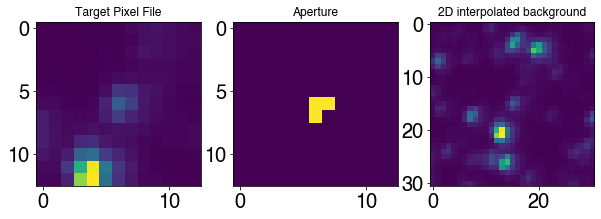

In [108]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,4))
ax1.imshow(data_1.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data_1.aperture)
ax2.set_title('Aperture')
ax3.imshow(data_1.bkg_tpf[0])
ax3.set_title('2D interpolated background');

In [130]:
kep_lc_1.interact_sky()

5.549999999994952


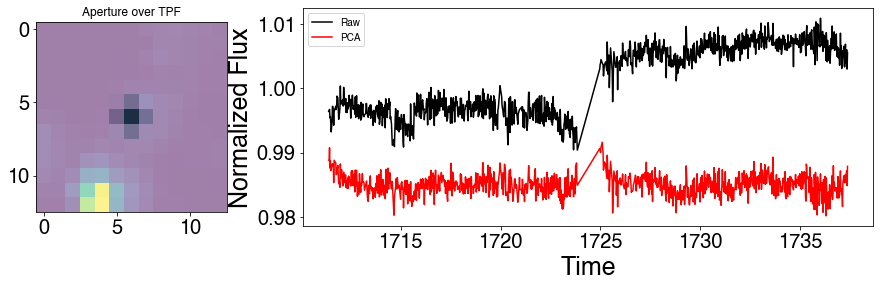

In [259]:
#eleanor.TargetData.custom_aperture(data_1, shape='circle', r=2, pos=[4,11], method='exact')
eleanor.TargetData.custom_aperture(data_1, shape='circle', r=1, pos=[6,6], method='exact')

eleanor.TargetData.get_lightcurve(data_1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data_1.tpf[0])
ax1.imshow(data_1.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data_1.time[q], data_1.raw_flux[q]/np.nanmedian(data_1.raw_flux[q]), 'k', label='Raw')
ax2.plot(data_1.time[q], data_1.pca_flux[q]/np.nanmedian(data_1.pca_flux[q]) - 0.015, 'r', label='PCA')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Flux');

time = data_1.time[q] 
flux_nan = (data_1.pca_flux[q])[~np.isnan(data_1.pca_flux[q])]
norm_flux = flux_nan/np.nanmedian(data_1.pca_flux[q])
   
norm_flux_err = np.sqrt(norm_flux)
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

        #cropping out section
mask = (time <= 1695) & (time >= 1690)
norm_flux_2 = norm_flux[~mask]
time_masked = time[~mask]
    
mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
norm_flux_mask = norm_flux_2[~mask_2]
time_mask = time_masked[~mask_2]

        #removing trends 
norm_flux_err_mask = np.sqrt(norm_flux_mask)
resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
resid_mask = resid_mask[~np.isnan(resid_mask)]
time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
f = interpolate.interp1d(time_mask, resid_mask)
xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
flux_mask = f(xnew_mask) 
flux_err_mask = np.sqrt(flux_mask)
    
#exo acf
ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

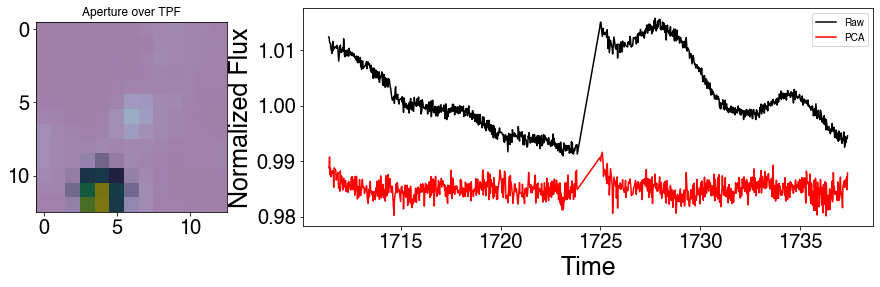

In [260]:
eleanor.TargetData.custom_aperture(data_1, shape='circle', r=2, pos=[4,11], method='exact')

eleanor.TargetData.get_lightcurve(data_1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data_1.tpf[0])
ax1.imshow(data_1.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data_1.time[q], data_1.raw_flux[q]/np.nanmedian(data_1.raw_flux[q]), 'k', label='Raw')
ax2.plot(data_1.time[q], data_1.pca_flux[q]/np.nanmedian(data_1.pca_flux[q]) - 0.015, 'r', label='PCA')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Flux');

# #2

In [241]:
star_2 = eleanor.Source(tic=271426791)
data_2 = eleanor.TargetData(star_2, do_psf=True, do_pca=True)
q = data_2.quality == 0

print('McQ Period: ', mcq_large_diff[2])
print('Calculated Period :', exo_per[2])

kep_lc_2 = search_targetpixelfile('TIC 271426791').download(quality_bitmask='default');
kep_lc_2.interact()

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:27<00:00, 42.94it/s]


McQ Period:  2.81
Calculated Period : 6.549999999994043


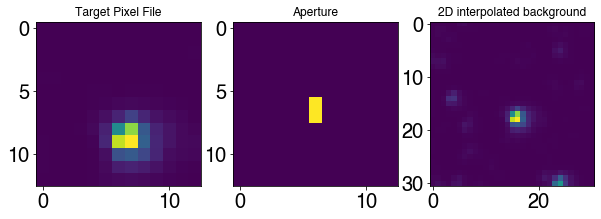

In [183]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,4))
ax1.imshow(data_2.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data_2.aperture)
ax2.set_title('Aperture')
ax3.imshow(data_2.bkg_tpf[0])
ax3.set_title('2D interpolated background');

kep_lc_2.interact_sky()

In [195]:
flux_err = np.sqrt(data_2.pca_flux[q])
ex_1 = exoplanet.autocorr_estimator(data_2.time[q], data_2.pca_flux[q], yerr= flux_err, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

8.197003827756362


6.549999999994043


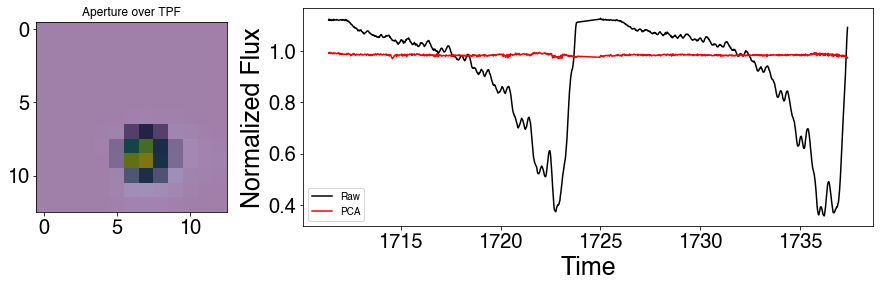

In [239]:
eleanor.TargetData.custom_aperture(data_2, shape='circle', r=2, pos=[7,8.5], method='exact')
eleanor.TargetData.get_lightcurve(data_2)
#data_2.save()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data_2.tpf[0])
ax1.imshow(data_2.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data_2.time[q], data_2.raw_flux[q]/np.nanmedian(data_2.raw_flux[q]), 'k', label='Raw')
ax2.plot(data_2.time[q], data_2.pca_flux[q]/np.nanmedian(data_2.pca_flux[q]) - 0.015, 'r', label='PCA')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Flux');

time = data_2.time[q] 
flux_nan = (data_2.pca_flux[q])[~np.isnan(data_2.pca_flux[q])]
norm_flux = flux_nan/np.nanmedian(data_2.pca_flux[q])
   
norm_flux_err = np.sqrt(norm_flux)
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

        #cropping out section
mask = (time <= 1695) & (time >= 1690)
norm_flux_2 = norm_flux[~mask]
time_masked = time[~mask]
    
mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
norm_flux_mask = norm_flux_2[~mask_2]
time_mask = time_masked[~mask_2]

        #removing trends 
norm_flux_err_mask = np.sqrt(norm_flux_mask)
resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
resid_mask = resid_mask[~np.isnan(resid_mask)]
time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
f = interpolate.interp1d(time_mask, resid_mask)
xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
flux_mask = f(xnew_mask) 
flux_err_mask = np.sqrt(flux_mask)
    
#exo acf
ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

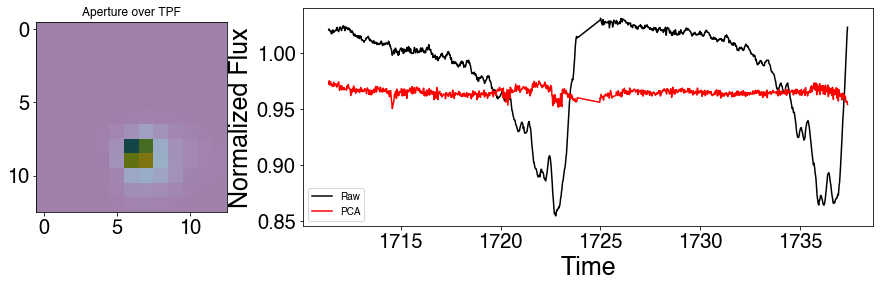

In [217]:
mask = np.zeros(np.shape(data_2.tpf[0]))
mask[8:10,6:8] = 1
data_2.get_lightcurve(aperture=mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data_2.tpf[0])
ax1.imshow(mask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data_2.time[q], data_2.raw_flux[q]/np.nanmedian(data_2.raw_flux[q]), 'k', label='Raw')
ax2.plot(data_2.time[q], data_2.pca_flux[q]/np.nanmedian(data_2.pca_flux[q]) - 0.035, 'r', label='PCA')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Flux');

In [220]:
vis = eleanor.Visualize(data_2)

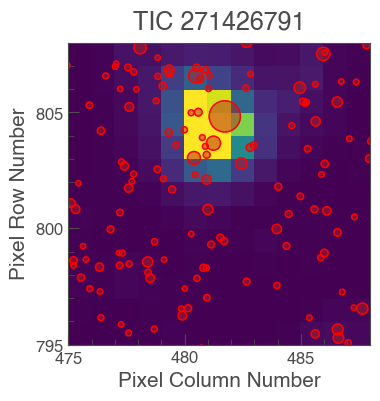

In [222]:
fig_gaia = vis.plot_gaia_overlay(magnitude_limit=19)

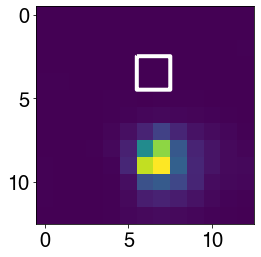

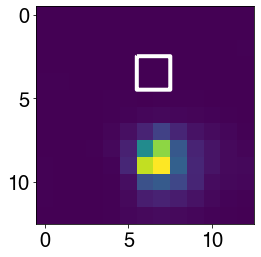

In [223]:
vis.aperture_contour()

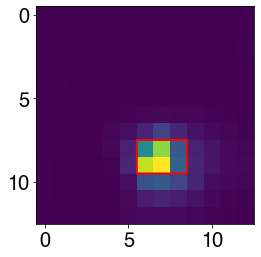

In [231]:
ap = np.zeros(data_2.tpf[0].shape)
ap[3:5,6:9] = 1
fig = vis.aperture_contour(aperture=ap, ap_color='r', ap_linewidth=2)

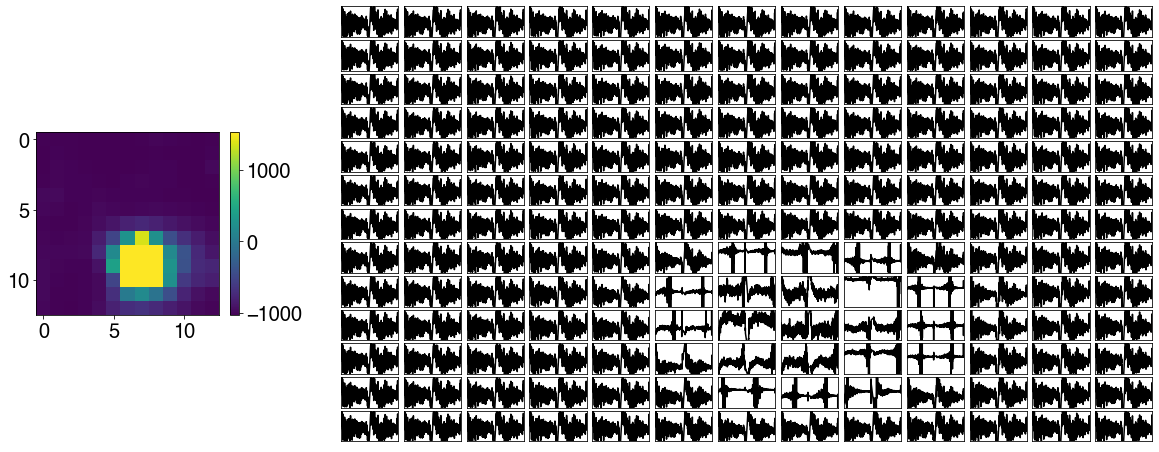

In [232]:
fig = vis.pixel_by_pixel()

In [236]:
data_2.get_lightcurve(aperture=ap)

time = data_2.time[q]
flux_nan = (data_2.pca_flux[q])[~np.isnan(data_2.pca_flux[q])]
norm_flux = flux_nan/np.nanmedian(data_2.pca_flux[q])
   
norm_flux_err = np.sqrt(norm_flux)
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

        #cropping out section
mask = (time <= 1695) & (time >= 1690)
norm_flux_2 = norm_flux[~mask]
time_masked = time[~mask]
    
mask_2 = (time_masked <= 1709) & (time_masked >= 1704)
norm_flux_mask = norm_flux_2[~mask_2]
time_mask = time_masked[~mask_2]

        #removing trends 
norm_flux_err_mask = np.sqrt(norm_flux_mask)
resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
resid_mask = resid_mask[~np.isnan(resid_mask)]
time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
f = interpolate.interp1d(time_mask, resid_mask)
xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
flux_mask = f(xnew_mask) 
flux_err_mask = np.sqrt(flux_mask)
    
#exo acf
ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

6.549999999994043


# #3

In [246]:
star_3 = eleanor.Source(tic=272719990)
data_3 = eleanor.TargetData(star_3, do_psf=True, do_pca=True)
q = data_3.quality == 0

print('McQ Period: ', mcq_large_diff[3])
print('Calculated Period :', exo_per[3])

kep_lc_3 = search_targetpixelfile('TIC 272719990').download(quality_bitmask='default');
kep_lc_3.interact()

No eleanor postcard has been made for your target (yet). Using TessCut instead.


100%|██████████| 1197/1197 [00:50<00:00, 23.70it/s]


McQ Period:  2.19
Calculated Period : 7.599999999993088


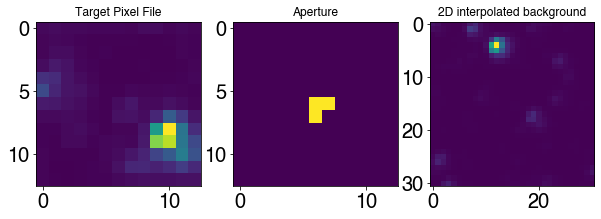

In [247]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,4))
ax1.imshow(data_3.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data_3.aperture)
ax2.set_title('Aperture')
ax3.imshow(data_3.bkg_tpf[0])
ax3.set_title('2D interpolated background');

In [248]:
kep_lc_3.interact_sky()

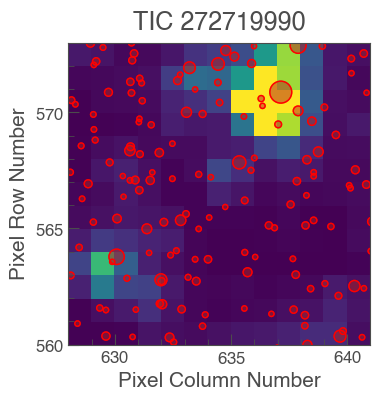

In [249]:
vis = eleanor.Visualize(data_3)
fig_gaia = vis.plot_gaia_overlay(magnitude_limit=19)

7.599999999993088


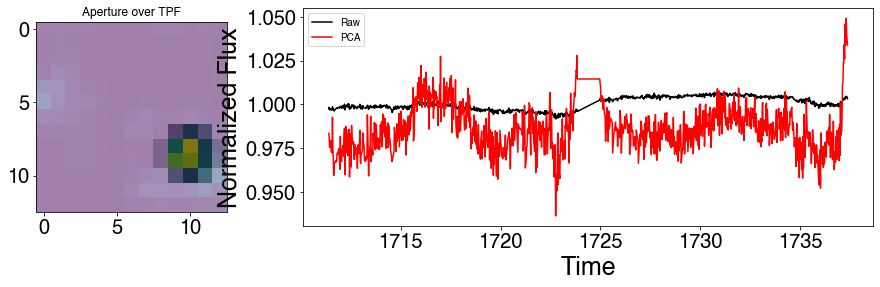

In [252]:
eleanor.TargetData.custom_aperture(data_3, shape='circle', r=2, pos=[10,8.5], method='exact')
eleanor.TargetData.get_lightcurve(data_3)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data_3.tpf[0])
ax1.imshow(data_3.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')

ax2.plot(data_3.time[q], data_3.raw_flux[q]/np.nanmedian(data_3.raw_flux[q]), 'k', label='Raw')
ax2.plot(data_3.time[q], data_3.pca_flux[q]/np.nanmedian(data_3.pca_flux[q]) - 0.015, 'r', label='PCA')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalized Flux');

time = data_3.time[q] 
flux_nan = (data_3.pca_flux[q])[~np.isnan(data_3.pca_flux[q])]
norm_flux = flux_nan/np.nanmedian(data_3.pca_flux[q])
   
norm_flux_err = np.sqrt(norm_flux)
resid = residuals(time, norm_flux, norm_flux_err)
resid = resid[~np.isnan(resid)]
time = time[~np.isnan(resid)]   
        
f = interpolate.interp1d(time, resid)
xnew = np.arange(time[0], time[-1], 0.1)
flux = f(xnew) 
flux_err = np.sqrt(flux)

        #cropping out section
mask = (time <= 1695) & (time >= 1690)
norm_flux_3 = norm_flux[~mask]
time_masked = time[~mask]
    
mask_3 = (time_masked <= 1709) & (time_masked >= 1704)
norm_flux_mask = norm_flux_3[~mask_3]
time_mask = time_masked[~mask_3]

        #removing trends 
norm_flux_err_mask = np.sqrt(norm_flux_mask)
resid_mask = residuals(time_mask, norm_flux_mask, norm_flux_err_mask)
resid_mask = resid_mask[~np.isnan(resid_mask)]
time_mask = time_mask[~np.isnan(resid_mask)]   
        
        #linear interpolation
f = interpolate.interp1d(time_mask, resid_mask)
xnew_mask = np.arange(time_mask[0], time_mask[-1], 0.1)
flux_mask = f(xnew_mask) 
flux_err_mask = np.sqrt(flux_mask)
    
#exo acf
ex_1 = exoplanet.autocorr_estimator(xnew_mask, flux_mask, yerr= flux_err_mask, min_period = 0.1, max_period = 15)
exo_period = ex_1['peaks'][0]['period']
print(exo_period)

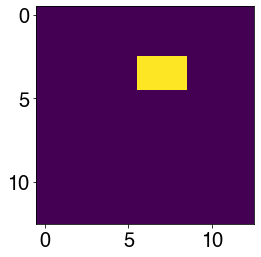

In [257]:
plt.imshow(data_3.aperture)

In [242]:
search = lk.search_targetpixelfile('TIC 272719990 c')

AttributeError: 'TessLightCurve' object has no attribute 'search_targetpixelfile'

In [ ]:
lc = search.to_lightcurve(aperture_mask='threshold');

In [253]:
thirty_m_large_diff[0:5]

['TIC171098535', 'TIC63209318', 'TIC271426791', 'TIC272719990', 'TIC360022896']